# Advanced Machine Learning Healthcare Coursework - Imaging
Candidate number: RLGJ6

In [30]:
import os
import numpy as np
from tqdm.notebook import tqdm # progress bars
from math import sqrt as sqrt
import heapq
from sklearn.metrics import jaccard_score # one of the metrics
from scipy.stats import ttest_ind

# figures and graphs
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seg_metrics.seg_metrics as sg

# pytorch
import torch # pytorch - deep learning library
from torchvision import datasets, transforms # pytorch add-ons
import torchvision # pytorch add-ons
from torch.utils.data.dataset import Dataset
from torch import nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F

# dealing with image files libraries
import glob # used for reading in files
from PIL import Image # image function library
import cv2 # used for computer vision
from scipy import ndimage, misc
from skimage import * # scikit image
import skimage.transform
import imageio

# data augmentations
import albumentations as A # data augmentations
from albumentations.pytorch import ToTensorV2
from functools import partial
import gc
import random


### Cuda-enabled: "mps" instead of "cuda" because this was done on an M1 Macbook Pro

In [31]:
# change if you want to use CPU or cuda
GPU_ENABLED_FLAG = True

if GPU_ENABLED_FLAG == True:
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device used: {device}")

Device used: mps


In [32]:
def imshow(image, ax=None, title=None, normalize=False):
    """Imshow for Tensors."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image,cmap='gray')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

# UNet Architecture
Code modified from idiomatic programmers tutorial on UNet architecture with Pytorch: https://idiomaticprogrammers.com/post/unet-architecture/

In [33]:
# double convolution module

class DoubleConv(nn.Module):
    # double conv module: two convolutions before each max pooling
    def __init__(self, in_channels, out_channels, kernel_size, strides, padding):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding, bias=False), # conv1
            nn.BatchNorm2d(num_features=out_channels), # batch normalisation to stablise training
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size, strides, padding), # conv2
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_segmentations=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList() # up layers (decoding path)

        self.downs = nn.ModuleList() # down layers (encoding path)
        
        
        self.bottleneck = DoubleConv(in_channels=features[-1],
                                    out_channels=features[-1]*2,
                                    kernel_size=3,
                                    strides=1,
                                    padding=1
                                    )
        
        # final output binary mask of input size
        self.output = nn.Conv2d(
            in_channels=features[0],
            out_channels=num_segmentations,
            kernel_size=1
        )
        
        # maxpooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        in_channels_iter = in_channels
        
        # adding layers to the down channels (contracting)
        for feature in features:
            self.downs.append(DoubleConv(
                in_channels=in_channels_iter,
                out_channels=feature,
                kernel_size=3,
                strides=1,
                padding=1
            ))
            in_channels_iter = feature
        
        # adding layers to the expanding path: convtranspose to upsample the images
        for feature in reversed(features):
            up = nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels=feature*2,
                    out_channels=feature,
                    kernel_size=2,
                    stride=2,
                    padding=0
                ),
                DoubleConv(
                    in_channels=feature*2,
                    out_channels=feature,
                    kernel_size=3,
                    padding=1,
                    strides=1
                )
            )

            self.ups.append(up)
    
    def forward(self, x):
        skip_connections = []
       
        # contracting path
        for down in self.downs:
            
            x = down(x) # send through the double conv
            skip_connections.append(x) # save the output for a later skip connection
            x = self.pool(x) # pool to the next down section

        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1] # reverse the skip connections for the expanding path
        
        # expanding path
        for i in range(len(self.ups)):
            x = self.ups[i][0](x) # passing through just the conv transpose

            skip_connection = skip_connections[i]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            
            # concatenating the output tensor with the skip connection
            concat_x = torch.cat((skip_connection, x), dim=1)

            # pass concatenated tensor through the double conv
            x = self.ups[i][1](concat_x)
        
        return self.output(x) # run through final layer to get 1 channel segmentation map



# Data configuration
SegmentationDataSet functions modified from the following website: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [34]:
class SegmentationDataSet_base(Dataset):
    """
    Reading the files in the paths, adding transformations for ease of use, creating a dataset
    """
    def __init__(self, imagePaths, maskPaths, transforms_img, transforms_mask):
        self.imagePaths = imagePaths # list of paths for each image in dataset
        self.maskPaths = maskPaths # list of paths for each mask in dataset, same order as the images
        self.transforms_img = transforms_img # torch.Compose list of transforms to apply to images
        self.transforms_mask = transforms_mask # " for masks
        

    def __len__(self):
        return len(self.imagePaths)
    
    def __getitem__(self, index):

        imagePath = self.imagePaths[index]
        
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 reads as BGR, looks strange when plotted so change back to RGB
        mask = cv2.imread(self.maskPaths[index], 0)

        image = self.transforms_img(image)
        mask = self.transforms_mask(mask)
        
        return (image, mask)

In [35]:
# same as the base class but this is adding the specular highlights removal

class SegmentationDataSet_preprocessed(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms_img, transforms_mask):
        self.imagePaths = imagePaths # list of paths for each image in dataset
        self.maskPaths = maskPaths # list of paths for each mask in dataset, same order as the images
        self.transforms_img = transforms_img # torch.Compose list of transforms to apply to images
        self.transforms_mask = transforms_mask # " for masks
        

    def __len__(self):
        return len(self.imagePaths)
    
    def __getitem__(self, index):
        
        # reading in the image
        imagePath = self.imagePaths[index]
        image = cv2.imread(imagePath)
        image = self.transforms_img(image)
        
        # change the format to agree with specular highlight removal
        image = image.numpy().squeeze().transpose((1,2,0))

        # normalising the image
        unnorm = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        # taking the first channel to make it greyscale
        unnorm_grey = unnorm.copy()[:, :,0]
        # threshold (keeping) the pixels with top 80% of intensity
        ex_mask = cv2.threshold(unnorm_grey, 0.8*np.max(unnorm_grey), np.max(unnorm_grey), cv2.THRESH_BINARY)[1]
        # turn into a binary mask of 0 and 255
        ex_mask[np.where(ex_mask > 200)] = 255
        # inpainting the normalised image with the binary mask with Navier stokes method
        ex_result = cv2.inpaint(unnorm.astype(np.uint8), ex_mask.astype(np.uint8), 
                                inpaintRadius=10, flags=cv2.INPAINT_NS)
        
        # turn image from BGR to RGB
        image = cv2.cvtColor(ex_result, cv2.COLOR_BGR2RGB)
        # read in the mask
        mask = cv2.imread(self.maskPaths[index], 0)
        
        # turn back into a tensor by doing torch transforms for image and mask
        image = self.transforms_img(image)
        mask = self.transforms_mask(mask)
        
        return (image, mask)

In [36]:
class SegmentationDataSet_augment(Dataset):
    def __init__(self, imagePaths, maskPaths, 
                 transforms_list, 
                 ppflag, aug_choice, aug_image, aug_mask):
        
        self.imagePaths = imagePaths  # list of paths for each image in dataset
        self.maskPaths = maskPaths # list of paths for each mask in dataset
        self.transforms_list = transforms_list # transforms to add at the beginning
        self.ppflag = ppflag # flag for preprocessing: 0 is none, 1 is specular highlight removal
        self.aug_choice = aug_choice # 0 to 5
        self.aug_image = aug_image # transforms to add to all images after augmentation
        self.aug_mask = aug_mask # transforms to add to all masks after augmentation

    def __len__(self):
        return len(self.imagePaths)
    
    def __getitem__(self, index):
        imagePath = self.imagePaths[index]

        image = cv2.imread(imagePath)
        
        if self.ppflag == True: # preprocessing as well
  
            image = self.transforms_list(image)
    
            mask = cv2.imread(self.maskPaths[index], 0)
            mask = self.transforms_list(mask)

            # change the format to agree with specular highlight removal
            image = image.numpy().squeeze().transpose((1,2,0))

            # normalising the image
            unnorm = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
            # taking the first channel to make it greyscale
            unnorm_grey = unnorm.copy()[:, :,0]
            # threshold (keeping) the pixels with top 80% of intensity
            ex_mask = cv2.threshold(unnorm_grey, 0.8*np.max(unnorm_grey), np.max(unnorm_grey), cv2.THRESH_BINARY)[1]
            # turn into a binary mask of 0 and 255
            ex_mask[np.where(ex_mask > 200)] = 255
            # inpainting the normalised image with the binary mask with Navier stokes method
            ex_result = cv2.inpaint(unnorm.astype(np.uint8), ex_mask.astype(np.uint8), 
                                    inpaintRadius=10, flags=cv2.INPAINT_NS)

            # turn image from BGR to RGB
            image = cv2.cvtColor(ex_result, cv2.COLOR_BGR2RGB)
        
            # adding augmentations
            mask = mask.numpy()
            transformed = self.aug_choice(image=image, mask=mask.squeeze())
            image = transformed['image']
            mask = transformed['mask'].squeeze() 

            # final transformations
            image = self.aug_image(image=image)['image']
            mask = self.aug_mask(image=mask)['image']
            
            
        elif self.ppflag == False: # no preprocessing
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(self.maskPaths[index], 0)
            
            # augmentations
            transformed = self.aug_choice(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

            # final transformations
            image = self.aug_image(image=image)['image']
            mask = self.aug_mask(image=mask)['image']

            
        return (image, mask)

# Creating datasets

In [37]:
# defining training configurations
grayscale_flag = False 
image_size = 100 # height and width of images


# directory of images
images_dir = glob.glob('Kvasir-SEG/images/*.jpg')

# directory of masks
masks_dir = glob.glob('Kvasir-SEG/masks/*.jpg')



In [38]:
len_data = len(images_dir)

# CHOOSING TRAINING DATA PROPORTION
split_props = [train_proportion, val_proportion, test_proportion] = [0.8, 0.1, 0.1]
split_sizes = [train_size, val_size, test_size] = [int(split_prop*len_data) for split_prop in split_props]

# raise error if doesn't sum to 1
if sum(split_props) != 1:
    raise ValueError("Train/val/test proportions don't add up to 1")
    

# transforms for images
transforms_list_img = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Resize([image_size, image_size]),
                                    transforms.Normalize((0.,0.,0.), (1.,1.,1.))])
# transforms for masks                                         
transforms_list_mask = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Resize([image_size, image_size]), 
                                    transforms.Normalize((0.,), (1.,))])
# transforms for images after augmentations
transforms_list_a = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Resize([image_size, image_size])])

# adding a greyscale transform
if grayscale_flag == True:
    transforms_list_img = transforms.Compose([transforms_list_img,
                                        transforms.Grayscale()])

In [39]:
# transforms for all the images being augmented
augmentation_all_img = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean=(0.,0.,0.), std=(1.,1.,1.)),
    ToTensorV2()
])

# transforms for all the masks being augmented
augmentation_all_mask = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean=(0.), std=(1.)),
    ToTensorV2()
])

# augmentations
augmentation_list = [
    A.Affine(scale=(0.5,1),p=1),
    A.Affine(rotate=(-90,90),p=1),
    A.Affine(shear=(-45,45),p=1),
    A.ElasticTransform(alpha=3000,sigma=40,p=1),
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
]



basic_augmented_datasets = [] # list to collect each augmented dataset
preprocessed_augmented_datasets = [] # list to collect each augmented AND preprocessed dataset

# looping through each augmentation
for i in range(len(augmentation_list)):
    basic_augmented_datasets.append(SegmentationDataSet_augment(imagePaths=images_dir[:train_size], 
                                                                maskPaths=masks_dir[:train_size],  
                                                                transforms_list=transforms_list_a,
                                                                ppflag=False,
                                                                aug_choice=augmentation_list[i],
                                                                aug_image=augmentation_all_img,
                                                                aug_mask=augmentation_all_mask))
    
    preprocessed_augmented_datasets.append(SegmentationDataSet_augment(imagePaths=images_dir[:train_size], 
                                                                       maskPaths=masks_dir[:train_size], 
                                                                       transforms_list=transforms_list_a,
                                                                       ppflag=True,
                                                                       aug_choice=augmentation_list[i],
                                                                       aug_image=augmentation_all_img,
                                                                       aug_mask=augmentation_all_mask))
    

# concatenate all the basic and processed datasets
basic_augmented = torch.utils.data.ConcatDataset(basic_augmented_datasets)
preprocessed_augmented = torch.utils.data.ConcatDataset(preprocessed_augmented_datasets)

In [40]:
# dataset of all images, not augmentation or prepreprocessing
basic_dataset = SegmentationDataSet_base(imagePaths=images_dir, 
                                         maskPaths=masks_dir, 
                                         transforms_img=transforms_list_img, 
                                         transforms_mask=transforms_list_mask)

# all images, specular highlights removed
preprocessed_dataset = SegmentationDataSet_preprocessed(imagePaths=images_dir, 
                                                        maskPaths=masks_dir, 
                                                        transforms_img=transforms_list_img, 
                                                        transforms_mask=transforms_list_mask)

# Figure creation: specular highlight removal

In [41]:
def tensor4d_to_plotnp(img):
    return img.numpy().squeeze().transpose((1,2,0))

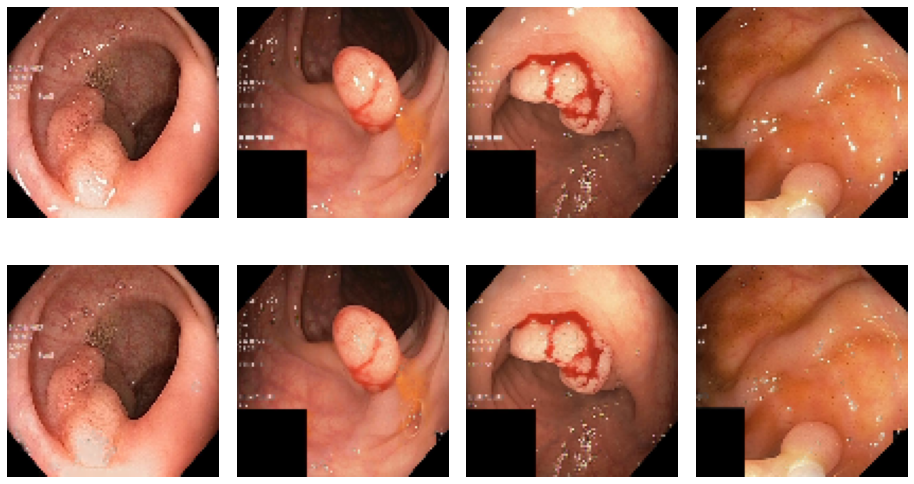

In [43]:
# dataloader for preprocessed images
ppdataloader = torch.utils.data.DataLoader(preprocessed_dataset, 
                                                        shuffle=False, 
                                                        batch_size=1, 
                                                        num_workers=0, 
                                                        pin_memory=False)
# dataloader for non-preprocessed images
noppdataloader = torch.utils.data.DataLoader(basic_dataset, 
                                                        shuffle=False, 
                                                        batch_size=1, 
                                                        num_workers=0, 
                                                        pin_memory=False)

ppiter = iter(ppdataloader)
noppiter = iter(noppdataloader)

fig, ax = plt.subplots(2,4,figsize=(13,8))


for i in range(4):
    im_p, mapp = next(ppiter)
    im_nopp, mapnopp = next(noppiter)

    ax[0,i].imshow(tensor4d_to_plotnp(im_nopp))
    ax[0,i].axis('off')
    ax[1,i].imshow(tensor4d_to_plotnp(im_p))
    ax[1,i].axis('off')

plt.tight_layout()
# plt.savefig("specularhighlightremoval.pdf")
plt.show()

In [42]:
def dataset_splitter(dataset, splits, batch_sz):
    """
    splits = train_size, val_size, test_size
    """
    train_dataset = torch.utils.data.Subset(dataset, 
                                            range(splits[0]))
    
    val_dataset = torch.utils.data.Subset(dataset, 
                                          range(splits[0], splits[0]+splits[1]))
    
    test_dataset = torch.utils.data.Subset(dataset, 
                                           range(splits[0]+splits[1], splits[0]+splits[1]+splits[2]))
    
    return train_dataset, val_dataset, test_dataset
    

# Figure: data examples, heatmap of polyp locations

In [46]:
# inspecting data imbalance
polyp_counter = np.zeros((image_size,image_size))

# complete dataloader
heatmap_dataloader = torch.utils.data.DataLoader(basic_dataset, 
                                                 shuffle=False, 
                                                 batch_size=1, 
                                                 num_workers=0, 
                                                 pin_memory=True)

seg_count = 0
non_seg_count = 0

# look over every grouth truth segmentation
for x,y in tqdm(heatmap_dataloader):
    y = (y > 0.5).float()
    seg_count += np.count_nonzero(y == 1)
    non_seg_count += np.count_nonzero(y == 0)
    polyp_counter = polyp_counter + y.numpy().squeeze()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
print(f"Percentage of polyp pixels over all images : {100*seg_count/(seg_count + non_seg_count):.2f}%")
print(f"Percentage of non-polyp pixels over all images : {100*non_seg_count/(seg_count + non_seg_count):.2f}%")

Percentage of polyp pixels over all images : 15.40%
Percentage of non-polyp pixels over all images : 84.60%


In [48]:
im, ma = next(iter(heatmap_dataloader))

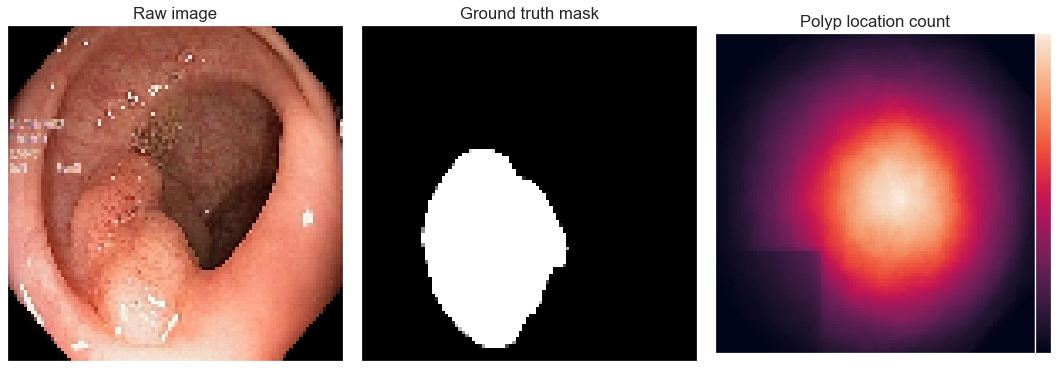

In [49]:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set(font_scale=1.4) 

fig, ax_hm_noda = plt.subplots(1,3,figsize=(15,10))

ax_hm_noda[0].imshow(tensor4d_to_plotnp(im))
ax_hm_noda[0].set_title("Raw image")

ax_hm_noda[1].imshow(ma.squeeze(), cmap='gray')
ax_hm_noda[1].set_title("Ground truth mask")


pos = ax_hm_noda[2].imshow(polyp_counter)
ax_hm_noda[2].set_title('Polyp location count')

divider = make_axes_locatable(ax_hm_noda[2])
cax = divider.append_axes("right", size="5%", pad=0.0)
fig.colorbar(pos,cax=cax)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.tight_layout()
# plt.savefig("data_example.pdf")
plt.show()

# Training functions

In [15]:
def final_performance_metric_calc(model, test_dataloader):
    """
    Model: trained U-net
    test_dataloader: dataloader of the data you want to test (validation or held-out test set)
    """
    
    
    # saving the metrics    
    metrics = {
        "jaccard": 0,
        "accuracy": 0,
        "sensitivity": 0,
        "specificity": 0,
        "TP": 0,
        "TN": 0,
        "FP": 0,
        "FN": 0        }
    
    
#     labels = [0, 1]
    
    # run the model over all the held-out test instances:
    model.to(device)
    model.eval()
    with torch.no_grad():
        for x, y in test_dataloader: # batch size of 1
            x = x.to(device)
            truth = (y>0.5).int().to(device)
            
            pred = model(x) # run through the model
            pred = torch.sigmoid(pred)
            pred = (pred > 0.5).int() # make it into a binary mask
            
            pred = pred.cpu()
            truth = truth.cpu()
            
            # jaccard score
            jaccard_val = jaccard_score(pred.int().flatten(),truth.int().flatten())
            metrics["jaccard"] += jaccard_val
        
            pred = pred.int().numpy()
            truth = truth.int().numpy()
            
            # pixel accuracy
            same = (truth == pred).sum()
            _, _, a, b = truth.shape
            total = a*b
            metrics["accuracy"] += same/total
            

            # Code modified from:
            # https://kawahara.ca/how-to-compute-truefalse-positives-and-truefalse-negatives-in-python-for-binary-classification-problems/

            # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
            TP = np.sum(np.logical_and(pred == 1, truth == 1))
            metrics["TP"] += TP

            # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
            TN = np.sum(np.logical_and(pred == 0, truth == 0))
            metrics["TN"] += TN

            # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
            FP = np.sum(np.logical_and(pred == 1, truth == 0))
            metrics["FP"] += FP

            # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
            FN = np.sum(np.logical_and(pred == 0, truth == 1))
            metrics["FN"] += FN
            
            metrics["sensitivity"] += TP / (TP + FN)
            metrics["specificity"] += TN / (TN + FP)
            
    
    
    metrics["jaccard"] = metrics["jaccard"]/len(test_dataloader)
    metrics["accuracy"] = metrics["accuracy"]/len(test_dataloader)
    metrics["sensitivity"] = metrics["sensitivity"]/len(test_dataloader)
    metrics["specificity"] = metrics["specificity"]/len(test_dataloader)
    
    return metrics
            
 


# Hyperparameter optimisation

In [15]:
def train_hyp_tuning(config_choices, loss_function, n_epochs):
    """
    Modified from:https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html
    
    Inputs:
    config_choices: dictionary of hyperparameter values for the search
    loss_function: loss function for the model
    n_epochs: int, how many epochs to run each search for
    """
    
    
    
    # *************************************************************
    # *************************************************************
    # ****************           DATA          ********************
    # *************************************************************
    # *************************************************************
    
    # hyperparameter values for this search
    lr_choice = config_choices['lr']
    batch_size_choice = config_choices['batch_size']
    data_aug_prop_choice = config_choices['data_aug_prop']
    flag_choice = config_choices['preprocessing_flag']
    
    # initialising model
    if grayscale_flag == True:
        net = UNet(1)
    elif grayscale_flag == False:
        net = UNet(3)
    net.to(device)

    criterion = loss_function
    optimiser = torch.optim.Adam(params=net.parameters(), lr=lr_choice)
    
    # preparing data
    if flag_choice == 1:
        train_subset, val_subset, _ = dataset_splitter(preprocessed_dataset, split_sizes, batch_size_choice)
        aug_set = preprocessed_augmented

    elif flag_choice == 0:
        train_subset, val_subset, _ = dataset_splitter(basic_dataset, split_sizes, batch_size_choice)
        aug_set = basic_augmented

    
    
    # random sample from aug_train_subset with hyperparameter optimisation
    lengths = [int(len(aug_set)*data_aug_prop_choice/100), 
               len(aug_set) - int(len(aug_set)*data_aug_prop_choice/100)]
    subsetA, subsetB = torch.utils.data.dataset.random_split(aug_set, lengths)
    
    # concatenate vanilla training set and augmented random sample
    train_and_aug_set = torch.utils.data.ConcatDataset([train_subset, subsetA])

    # making dataloaders
    trainloader = torch.utils.data.DataLoader(
        train_and_aug_set,
        batch_size=int(batch_size_choice),
        shuffle=True,
        num_workers=0,
        pin_memory=False)
    
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=1,
        shuffle=False,
        num_workers=0,
        pin_memory=False)
    
    # *************************************************************
    # *************************************************************
    # ****************        TRAINING         ********************
    # *************************************************************
    # *************************************************************
    training_loss_per_epoch = list()
    training_acc_per_epoch = list()
    val_loss_per_epoch = list()
    val_acc_per_epoch = list()
    
    for epoch in range(n_epochs):
        losses = list() # store the losses for each batch
        accs = list() # store the jaccard scores for each batch
        
        for x, y in trainloader:
            
            x = x.to(device) # image
            y = y.float().to(device) # ground truth segmentation

            # step 1 : forward 
            pred = net(x)

            # step 2 : compute objective function, don't need to sigmoid because it's with logits
            loss = criterion(pred, y)

            # step 3 : cleaning the gradient
            optimiser.zero_grad()

            # step 4 : accumulate partial derivatives 
            loss.backward()

            # step 5 : step in opposite direction to the gradient
            optimiser.step()

            # store the batch loss to the epoch loss list
            losses.append(loss.item())
 
            # store the batch accuracy to the epoch accuracy list
            pred = torch.sigmoid(pred)
            pred = (pred > 0.5).int()
            batch_acc = jaccard_score(pred.int().cpu().flatten(),y.int().cpu().flatten())
            accs.append(batch_acc)
            

        # printing the mean loss per epoch
        m_t_loss = torch.tensor(losses).mean().numpy()
        m_t_acc = torch.tensor(accs).mean().numpy()
        
        print(f"Epoch : {epoch+1} | Train Loss : {m_t_loss:.2f} | Train Jaccard : {m_t_acc:.2f} |")

        # store mean training loss per epoch
        training_loss_per_epoch.append(m_t_loss)

        # store mean training acc per epoch
        training_acc_per_epoch.append(m_t_acc)
        
        

        
        # *************************************************************
        # *************************************************************
        # ****************       VALIDATION        ********************
        # *************************************************************
        # *************************************************************
        
        val_losses = list()
        val_accs = list()
        net.eval()
        with torch.no_grad():
            for x, y in valloader: # batch size of 1
                x = x.to(device)
                y = y.to(device)

                pred = net(x)

                # validation loss
                val_losses.append(criterion(pred, y).item())

                # validation accuracy
                pred = torch.sigmoid(pred)
                pred = (pred > 0.5).int()
                val_accuracy = jaccard_score(pred.int().cpu().flatten(),y.int().cpu().flatten(),zero_division=0)
                val_accs.append(val_accuracy)

        net.train()

        m_v_loss = torch.tensor(val_losses).mean().numpy()
        m_v_acc = torch.tensor(val_accs).mean().numpy()
            
        print(f"Epoch : {epoch+1} | Val Loss   : {m_v_loss:.2f} | Val Jaccard   : {m_v_acc:.2f} |")
        
        # check_accuracy_and_save function will compute validation losses and accuracies 
        val_loss_per_epoch.append(m_v_loss)
        val_acc_per_epoch.append(m_v_acc)
        
        
    # train/val loss/jaccard logs for each epoch
    returning_metrics = [training_loss_per_epoch.copy(), training_acc_per_epoch.copy(),
            val_loss_per_epoch.copy(), val_acc_per_epoch.copy()]
    
    # removing items from memory

    del net
    del x
    del y
    del trainloader
    del valloader
    gc.collect()
    
    return returning_metrics
    

# Random search implementation

In [16]:
class Jaccard_Loss(nn.Module):
    # credit: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/
    def __init__(self, weight=None, size_average=True):
        super(Jaccard_Loss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [17]:
random_config = {
    "lr": [0.1, 0.01, 1e-3],
    "batch_size": [16, 32, 64], 
    "data_aug_prop": [10, 30, 50, 70],
    "preprocessing_flag": [1, 0]
    }

num_random_searches = 10 # number of random configurations of hps
num_epochs_trained = 20 # number of epochs to train for each combination

search_output = []

loss_fn = Jaccard_Loss()

### RUNNING RANDOM SEARCH

In [31]:
for i in range(num_random_searches): # for the ith random search
    
    # choosing the random combination
    choice_config = {
        "lr": random.sample(random_config["lr"],1)[0],
        "batch_size": random.sample(random_config["batch_size"],1)[0],
        "data_aug_prop": random.sample(random_config["data_aug_prop"],1)[0],
        "preprocessing_flag": random.sample(random_config["preprocessing_flag"],1)[0]
        }
    

    print("******************** NEW SEARCH ********************")
    print(choice_config)
    
    # training
    logs = np.stack(train_hyp_tuning(choice_config, loss_fn, num_epochs_trained))
    
    train_loss = logs[0]
    train_val = logs[1]
    val_loss = logs[2]
    val_acc = logs[3]
    
    # assigning the output values to stored list
    search_output.append([list(choice_config.values()), 
                         train_loss, train_val,
                         val_loss, val_acc])
    
    
    # printing outputs 

    
# UNCOMMENT IF SAVING OUTPUT
# np.save("random_search_100_search_output_20epochs_IoULoss.npy",search_output)

******************** NEW SEARCH ********************
{'lr': 0.01, 'batch_size': 32, 'data_aug_prop': 70, 'preprocessing_flag': 1}


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 1 | Train Loss : 0.94 | Train IoU : 0.06 |
Epoch : 1 | Val Loss   : 0.84 | Val IoU   : 0.16 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 2 | Train Loss : 0.92 | Train IoU : 0.08 |
Epoch : 2 | Val Loss   : 0.88 | Val IoU   : 0.12 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 3 | Train Loss : 0.86 | Train IoU : 0.14 |
Epoch : 3 | Val Loss   : 0.79 | Val IoU   : 0.21 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 4 | Train Loss : 0.82 | Train IoU : 0.18 |
Epoch : 4 | Val Loss   : 0.85 | Val IoU   : 0.15 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 5 | Train Loss : 0.80 | Train IoU : 0.19 |
Epoch : 5 | Val Loss   : 0.79 | Val IoU   : 0.20 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 6 | Train Loss : 0.79 | Train IoU : 0.21 |
Epoch : 6 | Val Loss   : 0.78 | Val IoU   : 0.21 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 7 | Train Loss : 0.78 | Train IoU : 0.21 |
Epoch : 7 | Val Loss   : 0.79 | Val IoU   : 0.20 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 8 | Train Loss : 0.77 | Train IoU : 0.23 |
Epoch : 8 | Val Loss   : 0.77 | Val IoU   : 0.21 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 9 | Train Loss : 0.77 | Train IoU : 0.23 |
Epoch : 9 | Val Loss   : 0.72 | Val IoU   : 0.27 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 10 | Train Loss : 0.76 | Train IoU : 0.24 |
Epoch : 10 | Val Loss   : 0.74 | Val IoU   : 0.25 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 11 | Train Loss : 0.75 | Train IoU : 0.24 |
Epoch : 11 | Val Loss   : 0.77 | Val IoU   : 0.22 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 12 | Train Loss : 0.75 | Train IoU : 0.24 |
Epoch : 12 | Val Loss   : 0.73 | Val IoU   : 0.26 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 13 | Train Loss : 0.74 | Train IoU : 0.25 |
Epoch : 13 | Val Loss   : 0.82 | Val IoU   : 0.17 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 14 | Train Loss : 0.73 | Train IoU : 0.26 |
Epoch : 14 | Val Loss   : 0.73 | Val IoU   : 0.25 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 15 | Train Loss : 0.73 | Train IoU : 0.26 |
Epoch : 15 | Val Loss   : 0.73 | Val IoU   : 0.25 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 16 | Train Loss : 0.73 | Train IoU : 0.26 |
Epoch : 16 | Val Loss   : 0.73 | Val IoU   : 0.26 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 17 | Train Loss : 0.72 | Train IoU : 0.27 |
Epoch : 17 | Val Loss   : 0.74 | Val IoU   : 0.24 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 18 | Train Loss : 0.72 | Train IoU : 0.28 |
Epoch : 18 | Val Loss   : 0.72 | Val IoU   : 0.26 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 19 | Train Loss : 0.71 | Train IoU : 0.28 |
Epoch : 19 | Val Loss   : 0.81 | Val IoU   : 0.18 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 20 | Train Loss : 0.70 | Train IoU : 0.29 |
Epoch : 20 | Val Loss   : 0.80 | Val IoU   : 0.19 |
******************** NEW SEARCH ********************
{'lr': 0.01, 'batch_size': 32, 'data_aug_prop': 70, 'preprocessing_flag': 0}


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 1 | Train Loss : 0.69 | Train IoU : 0.30 |
Epoch : 1 | Val Loss   : 0.71 | Val IoU   : 0.28 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 2 | Train Loss : 0.64 | Train IoU : 0.35 |
Epoch : 2 | Val Loss   : 0.72 | Val IoU   : 0.27 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 3 | Train Loss : 0.61 | Train IoU : 0.38 |
Epoch : 3 | Val Loss   : 0.67 | Val IoU   : 0.31 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 4 | Train Loss : 0.58 | Train IoU : 0.41 |
Epoch : 4 | Val Loss   : 0.63 | Val IoU   : 0.35 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 5 | Train Loss : 0.55 | Train IoU : 0.44 |
Epoch : 5 | Val Loss   : 0.63 | Val IoU   : 0.36 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 6 | Train Loss : 0.52 | Train IoU : 0.48 |
Epoch : 6 | Val Loss   : 0.59 | Val IoU   : 0.40 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 7 | Train Loss : 0.47 | Train IoU : 0.52 |
Epoch : 7 | Val Loss   : 0.52 | Val IoU   : 0.47 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 8 | Train Loss : 0.44 | Train IoU : 0.55 |
Epoch : 8 | Val Loss   : 0.66 | Val IoU   : 0.34 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 9 | Train Loss : 0.41 | Train IoU : 0.58 |
Epoch : 9 | Val Loss   : 0.47 | Val IoU   : 0.50 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 10 | Train Loss : 0.38 | Train IoU : 0.61 |
Epoch : 10 | Val Loss   : 0.47 | Val IoU   : 0.51 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 11 | Train Loss : 0.38 | Train IoU : 0.60 |
Epoch : 11 | Val Loss   : 0.45 | Val IoU   : 0.53 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 12 | Train Loss : 0.35 | Train IoU : 0.64 |
Epoch : 12 | Val Loss   : 0.33 | Val IoU   : 0.63 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 13 | Train Loss : 0.33 | Train IoU : 0.66 |
Epoch : 13 | Val Loss   : 0.36 | Val IoU   : 0.61 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 14 | Train Loss : 0.31 | Train IoU : 0.67 |
Epoch : 14 | Val Loss   : 0.32 | Val IoU   : 0.64 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 15 | Train Loss : 0.31 | Train IoU : 0.68 |
Epoch : 15 | Val Loss   : 0.35 | Val IoU   : 0.61 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 16 | Train Loss : 0.30 | Train IoU : 0.69 |
Epoch : 16 | Val Loss   : 0.34 | Val IoU   : 0.63 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 17 | Train Loss : 0.30 | Train IoU : 0.68 |
Epoch : 17 | Val Loss   : 0.34 | Val IoU   : 0.61 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 18 | Train Loss : 0.29 | Train IoU : 0.69 |
Epoch : 18 | Val Loss   : 0.30 | Val IoU   : 0.65 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 19 | Train Loss : 0.28 | Train IoU : 0.71 |
Epoch : 19 | Val Loss   : 0.27 | Val IoU   : 0.68 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 20 | Train Loss : 0.26 | Train IoU : 0.72 |
Epoch : 20 | Val Loss   : 0.29 | Val IoU   : 0.67 |
******************** NEW SEARCH ********************
{'lr': 0.001, 'batch_size': 32, 'data_aug_prop': 10, 'preprocessing_flag': 0}


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 1 | Train Loss : 0.75 | Train IoU : 0.28 |
Epoch : 1 | Val Loss   : 0.83 | Val IoU   : 0.16 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 2 | Train Loss : 0.68 | Train IoU : 0.34 |
Epoch : 2 | Val Loss   : 0.70 | Val IoU   : 0.31 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 3 | Train Loss : 0.63 | Train IoU : 0.38 |
Epoch : 3 | Val Loss   : 0.70 | Val IoU   : 0.29 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 4 | Train Loss : 0.59 | Train IoU : 0.41 |
Epoch : 4 | Val Loss   : 0.63 | Val IoU   : 0.36 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 5 | Train Loss : 0.56 | Train IoU : 0.44 |
Epoch : 5 | Val Loss   : 0.68 | Val IoU   : 0.31 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 6 | Train Loss : 0.53 | Train IoU : 0.46 |
Epoch : 6 | Val Loss   : 0.65 | Val IoU   : 0.33 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 7 | Train Loss : 0.51 | Train IoU : 0.48 |
Epoch : 7 | Val Loss   : 0.61 | Val IoU   : 0.38 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 8 | Train Loss : 0.48 | Train IoU : 0.50 |
Epoch : 8 | Val Loss   : 0.53 | Val IoU   : 0.44 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 9 | Train Loss : 0.46 | Train IoU : 0.52 |
Epoch : 9 | Val Loss   : 0.54 | Val IoU   : 0.45 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 10 | Train Loss : 0.44 | Train IoU : 0.55 |
Epoch : 10 | Val Loss   : 0.56 | Val IoU   : 0.42 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 11 | Train Loss : 0.42 | Train IoU : 0.56 |
Epoch : 11 | Val Loss   : 0.52 | Val IoU   : 0.46 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 12 | Train Loss : 0.40 | Train IoU : 0.58 |
Epoch : 12 | Val Loss   : 0.52 | Val IoU   : 0.46 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 13 | Train Loss : 0.38 | Train IoU : 0.60 |
Epoch : 13 | Val Loss   : 0.53 | Val IoU   : 0.46 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 14 | Train Loss : 0.37 | Train IoU : 0.61 |
Epoch : 14 | Val Loss   : 0.44 | Val IoU   : 0.54 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 15 | Train Loss : 0.37 | Train IoU : 0.61 |
Epoch : 15 | Val Loss   : 0.52 | Val IoU   : 0.46 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 16 | Train Loss : 0.35 | Train IoU : 0.63 |
Epoch : 16 | Val Loss   : 0.44 | Val IoU   : 0.54 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 17 | Train Loss : 0.32 | Train IoU : 0.66 |
Epoch : 17 | Val Loss   : 0.44 | Val IoU   : 0.53 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 18 | Train Loss : 0.31 | Train IoU : 0.67 |
Epoch : 18 | Val Loss   : 0.54 | Val IoU   : 0.42 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 19 | Train Loss : 0.31 | Train IoU : 0.67 |
Epoch : 19 | Val Loss   : 0.48 | Val IoU   : 0.49 |


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 20 | Train Loss : 0.31 | Train IoU : 0.67 |
Epoch : 20 | Val Loss   : 0.45 | Val IoU   : 0.52 |
******************** NEW SEARCH ********************
{'lr': 0.1, 'batch_size': 32, 'data_aug_prop': 70, 'preprocessing_flag': 1}


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 1 | Train Loss : 0.92 | Train IoU : 0.08 |
Epoch : 1 | Val Loss   : 0.81 | Val IoU   : 0.18 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 2 | Train Loss : 0.86 | Train IoU : 0.13 |
Epoch : 2 | Val Loss   : 0.83 | Val IoU   : 0.16 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 3 | Train Loss : 0.84 | Train IoU : 0.15 |
Epoch : 3 | Val Loss   : 0.87 | Val IoU   : 0.12 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 4 | Train Loss : 0.83 | Train IoU : 0.16 |
Epoch : 4 | Val Loss   : 0.94 | Val IoU   : 0.06 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 5 | Train Loss : 0.83 | Train IoU : 0.17 |
Epoch : 5 | Val Loss   : 0.83 | Val IoU   : 0.16 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 6 | Train Loss : 0.82 | Train IoU : 0.17 |
Epoch : 6 | Val Loss   : 0.87 | Val IoU   : 0.12 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 7 | Train Loss : 0.83 | Train IoU : 0.17 |
Epoch : 7 | Val Loss   : 0.85 | Val IoU   : 0.14 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 8 | Train Loss : 0.82 | Train IoU : 0.17 |
Epoch : 8 | Val Loss   : 0.80 | Val IoU   : 0.19 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 9 | Train Loss : 0.82 | Train IoU : 0.17 |
Epoch : 9 | Val Loss   : 0.82 | Val IoU   : 0.17 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 10 | Train Loss : 0.80 | Train IoU : 0.19 |
Epoch : 10 | Val Loss   : 0.87 | Val IoU   : 0.12 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 11 | Train Loss : 0.80 | Train IoU : 0.19 |
Epoch : 11 | Val Loss   : 0.86 | Val IoU   : 0.13 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 12 | Train Loss : 0.80 | Train IoU : 0.20 |
Epoch : 12 | Val Loss   : 0.82 | Val IoU   : 0.17 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 13 | Train Loss : 0.78 | Train IoU : 0.21 |
Epoch : 13 | Val Loss   : 0.83 | Val IoU   : 0.15 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 14 | Train Loss : 0.79 | Train IoU : 0.21 |
Epoch : 14 | Val Loss   : 0.85 | Val IoU   : 0.14 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 15 | Train Loss : 0.78 | Train IoU : 0.21 |
Epoch : 15 | Val Loss   : 0.80 | Val IoU   : 0.18 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 16 | Train Loss : 0.78 | Train IoU : 0.21 |
Epoch : 16 | Val Loss   : 0.80 | Val IoU   : 0.19 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 17 | Train Loss : 0.77 | Train IoU : 0.22 |
Epoch : 17 | Val Loss   : 0.76 | Val IoU   : 0.22 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 18 | Train Loss : 0.78 | Train IoU : 0.22 |
Epoch : 18 | Val Loss   : 0.82 | Val IoU   : 0.17 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 19 | Train Loss : 0.77 | Train IoU : 0.22 |
Epoch : 19 | Val Loss   : 0.81 | Val IoU   : 0.18 |


  0%|          | 0/130 [00:00<?, ?it/s]

Epoch : 20 | Train Loss : 0.76 | Train IoU : 0.23 |
Epoch : 20 | Val Loss   : 0.82 | Val IoU   : 0.17 |
******************** NEW SEARCH ********************
{'lr': 0.001, 'batch_size': 32, 'data_aug_prop': 50, 'preprocessing_flag': 1}


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 1 | Train Loss : 0.90 | Train IoU : 0.12 |
Epoch : 1 | Val Loss   : 0.76 | Val IoU   : 0.23 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 2 | Train Loss : 0.83 | Train IoU : 0.18 |
Epoch : 2 | Val Loss   : 0.77 | Val IoU   : 0.22 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 3 | Train Loss : 0.79 | Train IoU : 0.21 |
Epoch : 3 | Val Loss   : 0.85 | Val IoU   : 0.15 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 4 | Train Loss : 0.75 | Train IoU : 0.24 |
Epoch : 4 | Val Loss   : 0.90 | Val IoU   : 0.09 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 5 | Train Loss : 0.75 | Train IoU : 0.25 |
Epoch : 5 | Val Loss   : 0.77 | Val IoU   : 0.22 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 6 | Train Loss : 0.73 | Train IoU : 0.26 |
Epoch : 6 | Val Loss   : 0.82 | Val IoU   : 0.18 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 7 | Train Loss : 0.71 | Train IoU : 0.28 |
Epoch : 7 | Val Loss   : 0.75 | Val IoU   : 0.24 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 8 | Train Loss : 0.70 | Train IoU : 0.29 |
Epoch : 8 | Val Loss   : 0.75 | Val IoU   : 0.24 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 9 | Train Loss : 0.70 | Train IoU : 0.30 |
Epoch : 9 | Val Loss   : 0.74 | Val IoU   : 0.26 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 10 | Train Loss : 0.70 | Train IoU : 0.29 |
Epoch : 10 | Val Loss   : 0.70 | Val IoU   : 0.28 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 11 | Train Loss : 0.69 | Train IoU : 0.30 |
Epoch : 11 | Val Loss   : 0.69 | Val IoU   : 0.30 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 12 | Train Loss : 0.69 | Train IoU : 0.30 |
Epoch : 12 | Val Loss   : 0.70 | Val IoU   : 0.29 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 13 | Train Loss : 0.67 | Train IoU : 0.32 |
Epoch : 13 | Val Loss   : 0.80 | Val IoU   : 0.19 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 14 | Train Loss : 0.67 | Train IoU : 0.32 |
Epoch : 14 | Val Loss   : 0.70 | Val IoU   : 0.28 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 15 | Train Loss : 0.66 | Train IoU : 0.33 |
Epoch : 15 | Val Loss   : 0.71 | Val IoU   : 0.27 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 16 | Train Loss : 0.67 | Train IoU : 0.32 |
Epoch : 16 | Val Loss   : 0.69 | Val IoU   : 0.30 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 17 | Train Loss : 0.66 | Train IoU : 0.33 |
Epoch : 17 | Val Loss   : 0.74 | Val IoU   : 0.24 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 18 | Train Loss : 0.65 | Train IoU : 0.34 |
Epoch : 18 | Val Loss   : 0.69 | Val IoU   : 0.29 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 19 | Train Loss : 0.65 | Train IoU : 0.34 |
Epoch : 19 | Val Loss   : 0.69 | Val IoU   : 0.30 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 20 | Train Loss : 0.63 | Train IoU : 0.36 |
Epoch : 20 | Val Loss   : 0.76 | Val IoU   : 0.23 |
******************** NEW SEARCH ********************
{'lr': 0.01, 'batch_size': 32, 'data_aug_prop': 50, 'preprocessing_flag': 0}


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 1 | Train Loss : 0.70 | Train IoU : 0.30 |
Epoch : 1 | Val Loss   : 0.73 | Val IoU   : 0.25 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 2 | Train Loss : 0.66 | Train IoU : 0.33 |
Epoch : 2 | Val Loss   : 0.68 | Val IoU   : 0.31 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 3 | Train Loss : 0.63 | Train IoU : 0.37 |
Epoch : 3 | Val Loss   : 0.69 | Val IoU   : 0.29 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 4 | Train Loss : 0.61 | Train IoU : 0.38 |
Epoch : 4 | Val Loss   : 0.62 | Val IoU   : 0.36 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 5 | Train Loss : 0.58 | Train IoU : 0.41 |
Epoch : 5 | Val Loss   : 0.65 | Val IoU   : 0.33 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 6 | Train Loss : 0.55 | Train IoU : 0.44 |
Epoch : 6 | Val Loss   : 0.66 | Val IoU   : 0.32 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 7 | Train Loss : 0.53 | Train IoU : 0.46 |
Epoch : 7 | Val Loss   : 0.72 | Val IoU   : 0.27 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 8 | Train Loss : 0.50 | Train IoU : 0.49 |
Epoch : 8 | Val Loss   : 0.53 | Val IoU   : 0.45 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 9 | Train Loss : 0.46 | Train IoU : 0.53 |
Epoch : 9 | Val Loss   : 0.53 | Val IoU   : 0.46 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 10 | Train Loss : 0.43 | Train IoU : 0.56 |
Epoch : 10 | Val Loss   : 0.43 | Val IoU   : 0.55 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 11 | Train Loss : 0.41 | Train IoU : 0.58 |
Epoch : 11 | Val Loss   : 0.44 | Val IoU   : 0.53 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 12 | Train Loss : 0.38 | Train IoU : 0.61 |
Epoch : 12 | Val Loss   : 0.41 | Val IoU   : 0.56 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 13 | Train Loss : 0.37 | Train IoU : 0.61 |
Epoch : 13 | Val Loss   : 0.45 | Val IoU   : 0.52 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 14 | Train Loss : 0.35 | Train IoU : 0.63 |
Epoch : 14 | Val Loss   : 0.46 | Val IoU   : 0.52 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 15 | Train Loss : 0.33 | Train IoU : 0.65 |
Epoch : 15 | Val Loss   : 0.34 | Val IoU   : 0.62 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 16 | Train Loss : 0.32 | Train IoU : 0.66 |
Epoch : 16 | Val Loss   : 0.38 | Val IoU   : 0.60 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 17 | Train Loss : 0.31 | Train IoU : 0.68 |
Epoch : 17 | Val Loss   : 0.35 | Val IoU   : 0.63 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 18 | Train Loss : 0.30 | Train IoU : 0.69 |
Epoch : 18 | Val Loss   : 0.33 | Val IoU   : 0.63 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 19 | Train Loss : 0.29 | Train IoU : 0.69 |
Epoch : 19 | Val Loss   : 0.36 | Val IoU   : 0.60 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 20 | Train Loss : 0.28 | Train IoU : 0.71 |
Epoch : 20 | Val Loss   : 0.33 | Val IoU   : 0.63 |
******************** NEW SEARCH ********************
{'lr': 0.01, 'batch_size': 32, 'data_aug_prop': 50, 'preprocessing_flag': 1}


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 1 | Train Loss : 0.90 | Train IoU : 0.09 |
Epoch : 1 | Val Loss   : 0.90 | Val IoU   : 0.09 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 2 | Train Loss : 0.86 | Train IoU : 0.14 |
Epoch : 2 | Val Loss   : 0.73 | Val IoU   : 0.26 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 3 | Train Loss : 0.83 | Train IoU : 0.17 |
Epoch : 3 | Val Loss   : 0.79 | Val IoU   : 0.20 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 4 | Train Loss : 0.80 | Train IoU : 0.19 |
Epoch : 4 | Val Loss   : 0.82 | Val IoU   : 0.16 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 5 | Train Loss : 0.80 | Train IoU : 0.19 |
Epoch : 5 | Val Loss   : 0.80 | Val IoU   : 0.19 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 6 | Train Loss : 0.79 | Train IoU : 0.21 |
Epoch : 6 | Val Loss   : 0.79 | Val IoU   : 0.21 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 7 | Train Loss : 0.79 | Train IoU : 0.20 |
Epoch : 7 | Val Loss   : 0.85 | Val IoU   : 0.14 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 8 | Train Loss : 0.78 | Train IoU : 0.22 |
Epoch : 8 | Val Loss   : 0.73 | Val IoU   : 0.26 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 9 | Train Loss : 0.76 | Train IoU : 0.24 |
Epoch : 9 | Val Loss   : 0.76 | Val IoU   : 0.23 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 10 | Train Loss : 0.75 | Train IoU : 0.25 |
Epoch : 10 | Val Loss   : 0.77 | Val IoU   : 0.23 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 11 | Train Loss : 0.74 | Train IoU : 0.25 |
Epoch : 11 | Val Loss   : 0.73 | Val IoU   : 0.26 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 12 | Train Loss : 0.74 | Train IoU : 0.26 |
Epoch : 12 | Val Loss   : 0.81 | Val IoU   : 0.18 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 13 | Train Loss : 0.73 | Train IoU : 0.26 |
Epoch : 13 | Val Loss   : 0.77 | Val IoU   : 0.22 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 14 | Train Loss : 0.72 | Train IoU : 0.27 |
Epoch : 14 | Val Loss   : 0.74 | Val IoU   : 0.26 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 15 | Train Loss : 0.72 | Train IoU : 0.27 |
Epoch : 15 | Val Loss   : 0.77 | Val IoU   : 0.22 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 16 | Train Loss : 0.71 | Train IoU : 0.28 |
Epoch : 16 | Val Loss   : 0.77 | Val IoU   : 0.22 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 17 | Train Loss : 0.72 | Train IoU : 0.28 |
Epoch : 17 | Val Loss   : 0.79 | Val IoU   : 0.20 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 18 | Train Loss : 0.71 | Train IoU : 0.28 |
Epoch : 18 | Val Loss   : 0.73 | Val IoU   : 0.26 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 19 | Train Loss : 0.70 | Train IoU : 0.29 |
Epoch : 19 | Val Loss   : 0.74 | Val IoU   : 0.25 |


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 20 | Train Loss : 0.71 | Train IoU : 0.29 |
Epoch : 20 | Val Loss   : 0.82 | Val IoU   : 0.17 |
******************** NEW SEARCH ********************
{'lr': 0.1, 'batch_size': 32, 'data_aug_prop': 30, 'preprocessing_flag': 0}


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 1 | Train Loss : 0.70 | Train IoU : 0.29 |
Epoch : 1 | Val Loss   : 0.69 | Val IoU   : 0.30 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 2 | Train Loss : 0.66 | Train IoU : 0.34 |
Epoch : 2 | Val Loss   : 0.70 | Val IoU   : 0.29 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 3 | Train Loss : 0.64 | Train IoU : 0.36 |
Epoch : 3 | Val Loss   : 0.74 | Val IoU   : 0.24 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 4 | Train Loss : 0.62 | Train IoU : 0.38 |
Epoch : 4 | Val Loss   : 0.71 | Val IoU   : 0.27 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 5 | Train Loss : 0.61 | Train IoU : 0.38 |
Epoch : 5 | Val Loss   : 0.65 | Val IoU   : 0.33 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 6 | Train Loss : 0.58 | Train IoU : 0.41 |
Epoch : 6 | Val Loss   : 0.67 | Val IoU   : 0.32 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 7 | Train Loss : 0.57 | Train IoU : 0.42 |
Epoch : 7 | Val Loss   : 0.68 | Val IoU   : 0.31 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 8 | Train Loss : 0.54 | Train IoU : 0.45 |
Epoch : 8 | Val Loss   : 0.57 | Val IoU   : 0.41 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 9 | Train Loss : 0.51 | Train IoU : 0.48 |
Epoch : 9 | Val Loss   : 0.57 | Val IoU   : 0.40 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 10 | Train Loss : 0.49 | Train IoU : 0.50 |
Epoch : 10 | Val Loss   : 0.53 | Val IoU   : 0.45 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 11 | Train Loss : 0.47 | Train IoU : 0.52 |
Epoch : 11 | Val Loss   : 0.51 | Val IoU   : 0.47 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 12 | Train Loss : 0.44 | Train IoU : 0.55 |
Epoch : 12 | Val Loss   : 0.51 | Val IoU   : 0.48 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 13 | Train Loss : 0.43 | Train IoU : 0.56 |
Epoch : 13 | Val Loss   : 0.52 | Val IoU   : 0.46 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 14 | Train Loss : 0.42 | Train IoU : 0.57 |
Epoch : 14 | Val Loss   : 0.46 | Val IoU   : 0.53 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 15 | Train Loss : 0.39 | Train IoU : 0.59 |
Epoch : 15 | Val Loss   : 0.49 | Val IoU   : 0.49 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 16 | Train Loss : 0.39 | Train IoU : 0.60 |
Epoch : 16 | Val Loss   : 0.47 | Val IoU   : 0.51 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 17 | Train Loss : 0.36 | Train IoU : 0.62 |
Epoch : 17 | Val Loss   : 0.48 | Val IoU   : 0.50 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 18 | Train Loss : 0.37 | Train IoU : 0.62 |
Epoch : 18 | Val Loss   : 0.42 | Val IoU   : 0.56 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 19 | Train Loss : 0.35 | Train IoU : 0.63 |
Epoch : 19 | Val Loss   : 0.39 | Val IoU   : 0.59 |


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch : 20 | Train Loss : 0.34 | Train IoU : 0.65 |
Epoch : 20 | Val Loss   : 0.45 | Val IoU   : 0.51 |
******************** NEW SEARCH ********************
{'lr': 0.1, 'batch_size': 16, 'data_aug_prop': 50, 'preprocessing_flag': 0}


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 1 | Train Loss : 0.70 | Train IoU : 0.30 |
Epoch : 1 | Val Loss   : 0.75 | Val IoU   : 0.23 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 2 | Train Loss : 0.66 | Train IoU : 0.33 |
Epoch : 2 | Val Loss   : 0.78 | Val IoU   : 0.23 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 3 | Train Loss : 0.65 | Train IoU : 0.34 |
Epoch : 3 | Val Loss   : 0.68 | Val IoU   : 0.30 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 4 | Train Loss : 0.65 | Train IoU : 0.34 |
Epoch : 4 | Val Loss   : 0.77 | Val IoU   : 0.23 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 5 | Train Loss : 0.64 | Train IoU : 0.36 |
Epoch : 5 | Val Loss   : 0.67 | Val IoU   : 0.31 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 6 | Train Loss : 0.61 | Train IoU : 0.39 |
Epoch : 6 | Val Loss   : 0.74 | Val IoU   : 0.26 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 7 | Train Loss : 0.58 | Train IoU : 0.41 |
Epoch : 7 | Val Loss   : 0.66 | Val IoU   : 0.33 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 8 | Train Loss : 0.56 | Train IoU : 0.44 |
Epoch : 8 | Val Loss   : 0.58 | Val IoU   : 0.40 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 9 | Train Loss : 0.53 | Train IoU : 0.46 |
Epoch : 9 | Val Loss   : 0.55 | Val IoU   : 0.43 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 10 | Train Loss : 0.50 | Train IoU : 0.49 |
Epoch : 10 | Val Loss   : 0.58 | Val IoU   : 0.40 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 11 | Train Loss : 0.48 | Train IoU : 0.51 |
Epoch : 11 | Val Loss   : 0.54 | Val IoU   : 0.44 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 12 | Train Loss : 0.45 | Train IoU : 0.54 |
Epoch : 12 | Val Loss   : 0.54 | Val IoU   : 0.44 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 13 | Train Loss : 0.42 | Train IoU : 0.56 |
Epoch : 13 | Val Loss   : 0.48 | Val IoU   : 0.48 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 14 | Train Loss : 0.42 | Train IoU : 0.57 |
Epoch : 14 | Val Loss   : 0.47 | Val IoU   : 0.50 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 15 | Train Loss : 0.39 | Train IoU : 0.60 |
Epoch : 15 | Val Loss   : 0.40 | Val IoU   : 0.57 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 16 | Train Loss : 0.37 | Train IoU : 0.61 |
Epoch : 16 | Val Loss   : 0.46 | Val IoU   : 0.52 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 17 | Train Loss : 0.37 | Train IoU : 0.62 |
Epoch : 17 | Val Loss   : 0.40 | Val IoU   : 0.58 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 18 | Train Loss : 0.35 | Train IoU : 0.63 |
Epoch : 18 | Val Loss   : 0.43 | Val IoU   : 0.54 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 19 | Train Loss : 0.35 | Train IoU : 0.64 |
Epoch : 19 | Val Loss   : 0.50 | Val IoU   : 0.49 |


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch : 20 | Train Loss : 0.34 | Train IoU : 0.64 |
Epoch : 20 | Val Loss   : 0.42 | Val IoU   : 0.56 |
******************** NEW SEARCH ********************
{'lr': 0.001, 'batch_size': 16, 'data_aug_prop': 30, 'preprocessing_flag': 0}


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 1 | Train Loss : 0.73 | Train IoU : 0.29 |
Epoch : 1 | Val Loss   : 0.73 | Val IoU   : 0.26 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 2 | Train Loss : 0.67 | Train IoU : 0.33 |
Epoch : 2 | Val Loss   : 0.73 | Val IoU   : 0.25 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 3 | Train Loss : 0.63 | Train IoU : 0.36 |
Epoch : 3 | Val Loss   : 0.65 | Val IoU   : 0.33 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 4 | Train Loss : 0.60 | Train IoU : 0.39 |
Epoch : 4 | Val Loss   : 0.66 | Val IoU   : 0.33 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 5 | Train Loss : 0.57 | Train IoU : 0.42 |
Epoch : 5 | Val Loss   : 0.62 | Val IoU   : 0.36 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 6 | Train Loss : 0.55 | Train IoU : 0.44 |
Epoch : 6 | Val Loss   : 0.80 | Val IoU   : 0.19 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 7 | Train Loss : 0.52 | Train IoU : 0.47 |
Epoch : 7 | Val Loss   : 0.58 | Val IoU   : 0.40 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 8 | Train Loss : 0.48 | Train IoU : 0.51 |
Epoch : 8 | Val Loss   : 0.56 | Val IoU   : 0.42 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 9 | Train Loss : 0.46 | Train IoU : 0.53 |
Epoch : 9 | Val Loss   : 0.56 | Val IoU   : 0.42 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 10 | Train Loss : 0.42 | Train IoU : 0.57 |
Epoch : 10 | Val Loss   : 0.48 | Val IoU   : 0.50 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 11 | Train Loss : 0.42 | Train IoU : 0.56 |
Epoch : 11 | Val Loss   : 0.51 | Val IoU   : 0.46 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 12 | Train Loss : 0.38 | Train IoU : 0.60 |
Epoch : 12 | Val Loss   : 0.46 | Val IoU   : 0.51 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 13 | Train Loss : 0.38 | Train IoU : 0.61 |
Epoch : 13 | Val Loss   : 0.42 | Val IoU   : 0.55 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 14 | Train Loss : 0.35 | Train IoU : 0.63 |
Epoch : 14 | Val Loss   : 0.39 | Val IoU   : 0.57 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 15 | Train Loss : 0.36 | Train IoU : 0.63 |
Epoch : 15 | Val Loss   : 0.39 | Val IoU   : 0.58 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 16 | Train Loss : 0.35 | Train IoU : 0.63 |
Epoch : 16 | Val Loss   : 0.36 | Val IoU   : 0.60 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 17 | Train Loss : 0.33 | Train IoU : 0.65 |
Epoch : 17 | Val Loss   : 0.38 | Val IoU   : 0.58 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 18 | Train Loss : 0.32 | Train IoU : 0.67 |
Epoch : 18 | Val Loss   : 0.38 | Val IoU   : 0.58 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 19 | Train Loss : 0.31 | Train IoU : 0.67 |
Epoch : 19 | Val Loss   : 0.37 | Val IoU   : 0.60 |


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch : 20 | Train Loss : 0.30 | Train IoU : 0.68 |
Epoch : 20 | Val Loss   : 0.34 | Val IoU   : 0.62 |


/Users/florencetownend/pytorch-test/env/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# Figure: train-test logs for hyperparameter optimsation

In [18]:
colours = ["#c72fcc", "#e95b07", "#3fb02e","#748ed7"]

In [19]:
loaded_output = np.load("toload/random_search_100_search_output_20epochs_IoULoss.npy",allow_pickle=True)

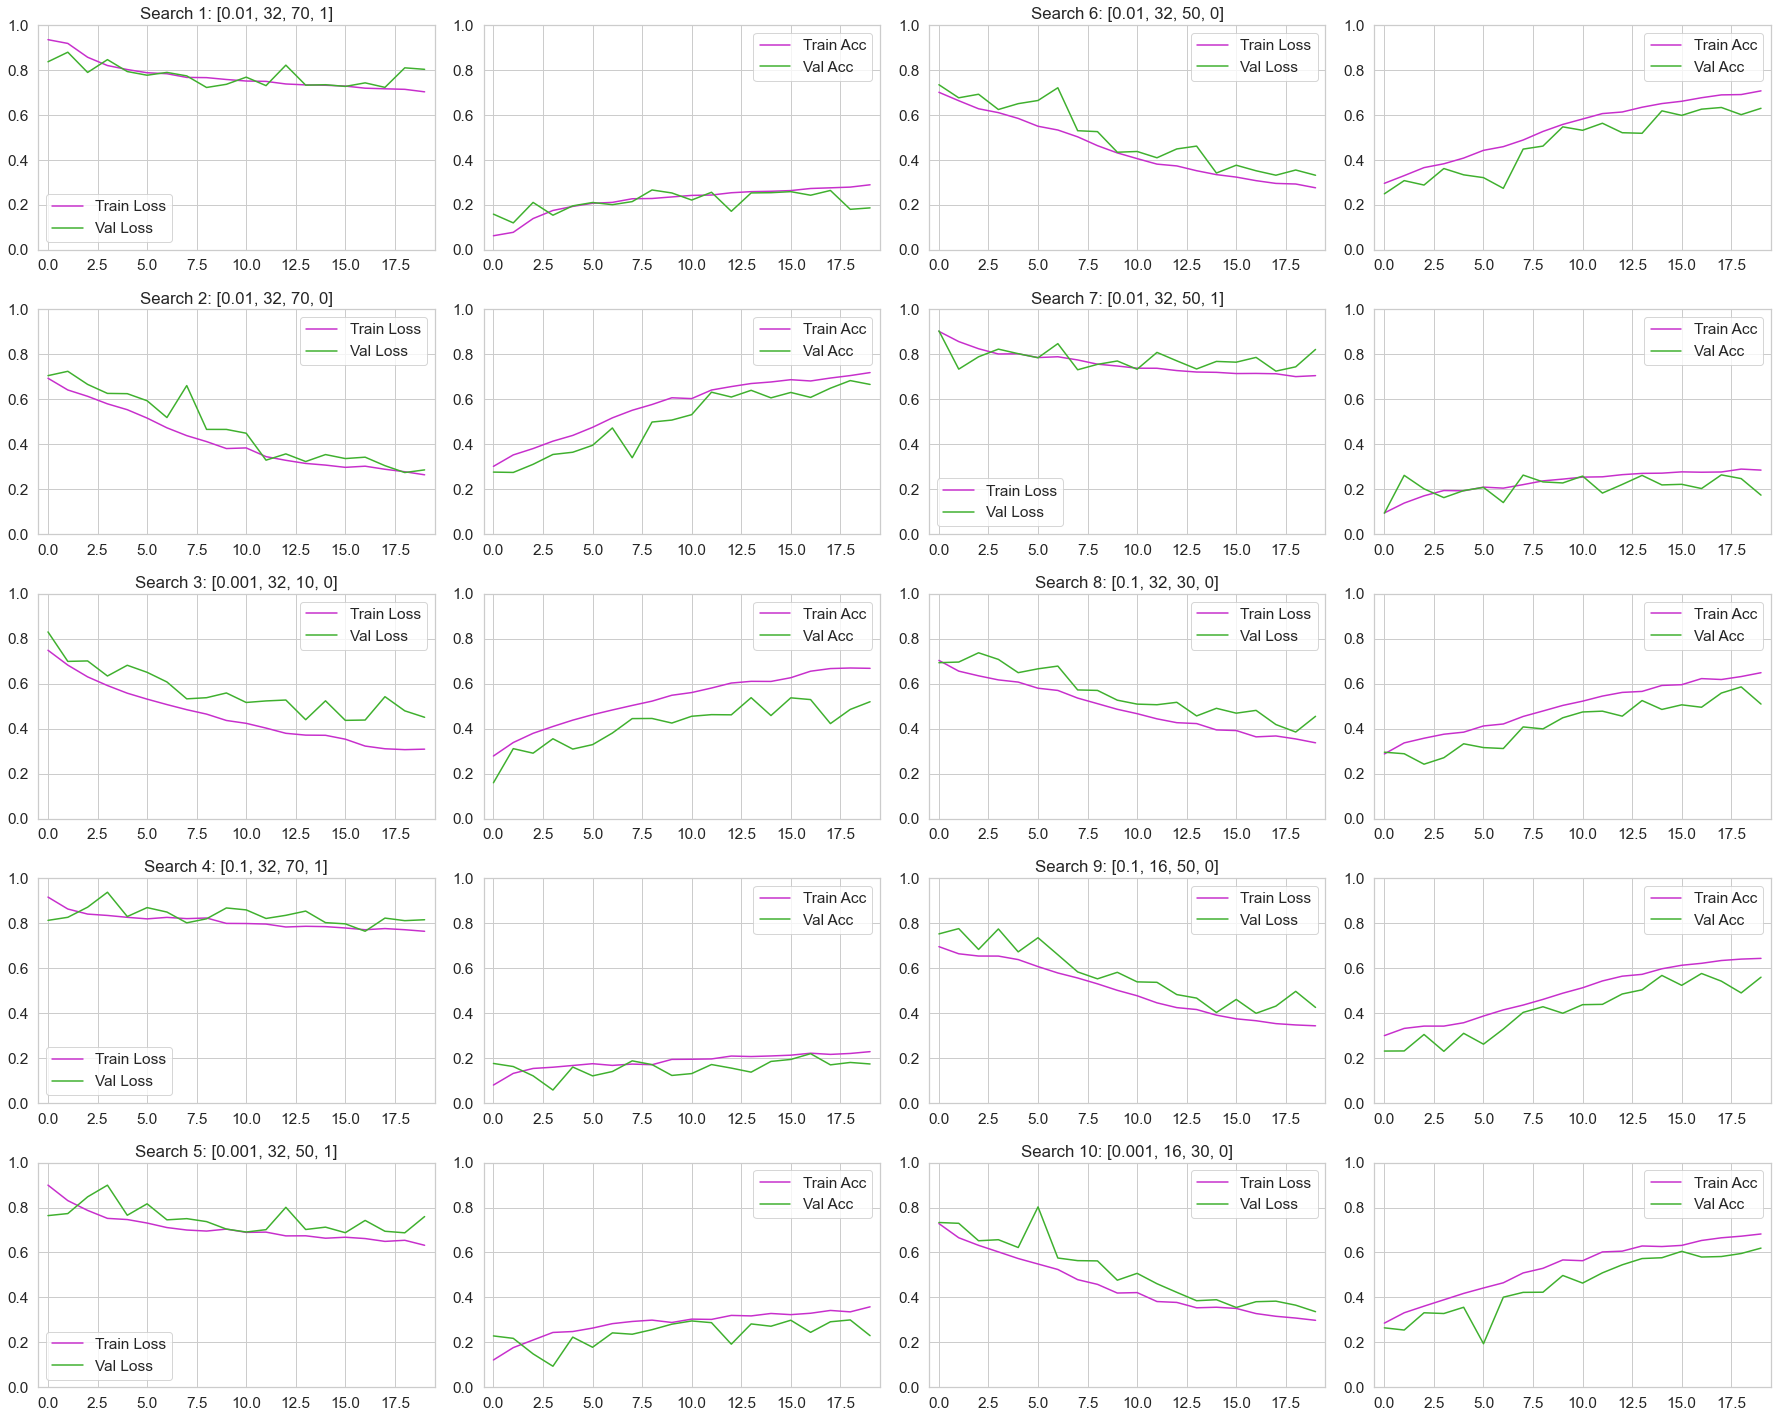

In [20]:
x_epoch = np.arange(20)
sns.set(font_scale=1.4) 
sns.set_style("whitegrid", {'axes.grid' : True})
labels=['Train Loss', 'Val Loss', 'Train Acc', 'Val Acc']

fig, ax = plt.subplots(5,4,figsize=(25,20))

for i in range(5):
    ax[i,0].plot(x_epoch,loaded_output[:,1:][i][0], label=labels[0],color=colours[0])
    ax[i,0].plot(x_epoch,loaded_output[:,1:][i][2], label=labels[1],color=colours[2])

    ax[i,1].plot(x_epoch,loaded_output[:,1:][i][1], label=labels[2],color=colours[0])
    ax[i,1].plot(x_epoch,loaded_output[:,1:][i][3], label=labels[3],color=colours[2])

    ax[i,0].set_title(f"Search {i+1}: {loaded_output[:,0][i]}")
    ax[i,0].legend()
    ax[i,1].legend()
    
    ax[i,2].plot(x_epoch,loaded_output[:,1:][i+5][0], label=labels[0],color=colours[0])
    ax[i,2].plot(x_epoch,loaded_output[:,1:][i+5][2], label=labels[1],color=colours[2])

    ax[i,3].plot(x_epoch,loaded_output[:,1:][i+5][1], label=labels[2],color=colours[0])
    ax[i,3].plot(x_epoch,loaded_output[:,1:][i+5][3], label=labels[3],color=colours[2])

    ax[i,2].set_title(f"Search {i+6}: {loaded_output[:,0][i+5]}")
    ax[i,2].legend()
    ax[i,3].legend()


plt.setp(ax, xlim=(-0.5,19.5), ylim=(0,1))
plt.tight_layout()
# plt.savefig("random_search_logs_grid.pdf")
plt.show()

# Choosing the best hyperparameters

In [57]:
# average slopes of loss and validation curves

slopes = []

for i in range(len(loaded_output)): # for each random search, fit a linear slope to it
    train_loss_slope = np.polyfit(x_epoch,loaded_output[i][1],1)[0]
    train_acc_slope = np.polyfit(x_epoch,loaded_output[i][2],1)[0]
    val_loss_slope = np.polyfit(x_epoch,loaded_output[i][3],1)[0]
    val_acc_slope = np.polyfit(x_epoch,loaded_output[i][4],1)[0]
    
    slopes.append([loaded_output[i][0], 
                   train_loss_slope, 
                   val_loss_slope, 
                   train_acc_slope, 
                   val_acc_slope])

In [58]:
def avg_slope_maker(vals, slopes, idx, slopes_list, avg_slopes_list):
    """
    Collects the average slopes of the random searches for each value of a hyperparameter
    
    input:
    vals = list of hyperparameter values for the hyperparameter in question
    slopes = slopes list from the random search
    idx = which position of the hyperparameter config does the hyperparameter in question sit e.g. lr is the first, so idx = 0
    slopes_list = empty nested list for the slopes for each hyperparameter
    avg_slopes_list = empty nested list for the average slopes for each hyperparameter
    """
    for i in range(len(slopes)): # for each slope
        for j in range(len(vals)): # for each of the possible hyperparameter values
            if slopes[i][0][idx] == vals[j]: # if one of the hyperparameters is == vals[j] e.g. lr=0.01
                slopes_list[j][0].append(slopes[i][1])
                slopes_list[j][1].append(slopes[i][2])
                slopes_list[j][2].append(slopes[i][3])
                slopes_list[j][3].append(slopes[i][4])

    avg_slopes = avg_slopes_list
    for i in range(len(slopes_list)):
        for j in range(len(slopes_list[i])):
            avg_slopes[i].append(np.mean(slopes_list[i][j]))
        
    return avg_slopes

In [59]:
# learning rate
lr_slopes_avg = avg_slope_maker([0.1,0.01,0.001], slopes, 0,[[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]],[[],[],[]])

# batch size
batch_slopes_avg = avg_slope_maker([16, 32], slopes, 1,[[[],[],[],[]],[[],[],[],[]]],[[],[],[]])

# data augmentation proportion
da_slopes_avg = avg_slope_maker([10, 30, 50, 70], slopes, 2,[[[],[],[],[]],[[],[],[],[]],[[],[],[],[]],[[],[],[],[]]],[[],[],[],[]])

# preprocessing flag
pp_slopes_avg = avg_slope_maker([0,1], slopes, 3,[[[],[],[],[]],[[],[],[],[]]],[[],[]])


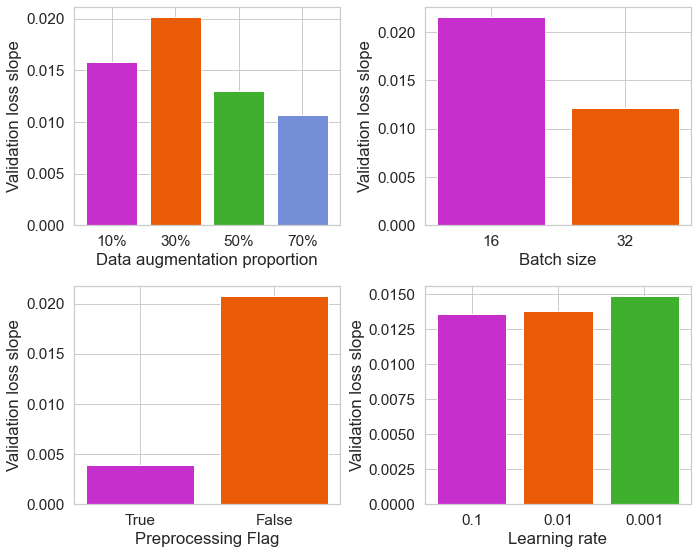

In [66]:
sns.set(font_scale=1.4) 
sns.set_style("whitegrid", {'axes.grid' : True})

fig, ax = plt.subplots(2,2,figsize=(10,8))

# data augmentation graph
bar_width = 0.8
opacity = 1

ax[0,0].bar(0, abs(da_slopes_avg[0][1]), bar_width,
alpha=opacity,
color=colours[0],
label='10%')

ax[0,0].bar(1, abs(da_slopes_avg[1][1]), bar_width,
alpha=opacity,
color=colours[1],
label='30%')

ax[0,0].bar(2, abs(da_slopes_avg[2][1]), bar_width,
alpha=opacity,
color=colours[2],
label='50%')

ax[0,0].bar(3, abs(da_slopes_avg[3][1]), bar_width,
alpha=opacity,
color=colours[3],
label='70%')

ax[0,0].set_xlabel('Data augmentation proportion')
ax[0,0].set_ylabel('Validation loss slope')
ax[0,0].set_xticks([0,1,2,3], ["10%", "30%", "50%", "70%"])



# batch size
rects1 = ax[0,1].bar(0, abs(batch_slopes_avg[0][1]), bar_width,
alpha=opacity,
color=colours[0],
label='10%')

rects2 = ax[0,1].bar(1, abs(batch_slopes_avg[1][1]), bar_width,
alpha=opacity,
color=colours[1],
label='30%')

ax[0,1].set_xlabel('Batch size')
ax[0,1].set_ylabel('Validation loss slope')
ax[0,1].set_xticks([0,1], ["16", "32"])


# preprocessing

ax[1,0].bar(1, abs(pp_slopes_avg[0][1]), bar_width,
alpha=opacity,
color=colours[1],
label='10%')

ax[1,0].bar(0, abs(pp_slopes_avg[1][1]), bar_width,
alpha=opacity,
color=colours[0],
label='30%')
 
ax[1,0].set_xlabel('Preprocessing Flag')
ax[1,0].set_ylabel('Validation loss slope')
ax[1,0].set_xticks([0,1], ["True", "False"])



# learning rate

ax[1,1].bar(0, abs(lr_slopes_avg[0][1]), bar_width,
alpha=opacity,
color=colours[0],
label='10%')

ax[1,1].bar(1, abs(lr_slopes_avg[1][1]), bar_width,
alpha=opacity,
color=colours[1],
label='30%')
 
ax[1,1].bar(2, abs(lr_slopes_avg[2][1]), bar_width,
alpha=opacity,
color=colours[2],
label='30%')

ax[1,1].set_xlabel('Learning rate')
ax[1,1].set_ylabel('Validation loss slope')
ax[1,1].set_xticks([0,1,2], ["0.1", "0.01", "0.001"])


plt.tight_layout()
# plt.savefig("hyp_results_4.pdf")
plt.show()

# Completely training the models 

In [52]:
def final_tune(loss_function, model, n_epochs, metrics_collector, data,hps,filepath):
    """
    Training the final models.
    
    Inputs:
    loss_function = loss function for this model
    model = Unet
    n_epochs = number of epochs to train for
    metrics_collector = dictionary, one key for every metric, values is an empty list
    data = list containing dataloaders for train dataset and val dataset
    hps = list of hyperparameters [learning rate, batch size, data augmentation proportion, preprocessing flag]
    filepath = directory to save model epochs
    """
    
    model.to(device)
    optimiser = torch.optim.Adam(params=model.parameters(), lr=hps[0])
    
    [trainloader, valloader] = data
    
    training_loss_per_epoch = list()
    training_acc_per_epoch = list()
    val_loss_per_epoch = list()
    val_acc_per_epoch = list()
    
    for epoch in range(n_epochs):
        losses = list()
        accs = list()

        for x, y in tqdm(trainloader):

            x = x.to(device) # image
            y = y.float().to(device) # ground truth segmentation

            # step 1 : forward 
            pred = model(x)

            # step 2 : compute objective function, don't need to sigmoid because it's with logits
            loss = loss_function(pred, y)

            # step 3 : cleaning the gradient
            optimiser.zero_grad()

            # step 4 : accumulate partial derivatives 
            loss.backward()

            # step 5 : step in opposite direction to the gradient
            optimiser.step()

            # store the batch loss to the epoch loss list
            losses.append(loss.item())
 
            # store the batch accuracy to the epoch accuracy list
            pred = torch.sigmoid(pred)
            pred = (pred > 0.5).int()
            
            batch_acc = jaccard_score(pred.int().cpu().flatten(),y.int().cpu().flatten())
            accs.append(batch_acc)
            
        # printing the mean loss per epoch
        m_t_loss = torch.tensor(losses).mean().numpy()
        m_t_acc = torch.tensor(accs).mean().numpy()
        
        print(f"Epoch : {epoch+1} | Train Loss : {m_t_loss:.2f} | Train Jaccard : {m_t_acc:.2f} |")

        # store mean training loss per epoch
        training_loss_per_epoch.append(m_t_loss)

        # store mean training acc per epoch
        training_acc_per_epoch.append(m_t_acc)
        
        

        
        # *************************************************************
        # *************************************************************
        # ****************       VALIDATION        ********************
        # *************************************************************
        # *************************************************************
        
        val_losses = list()
        val_accs = list()
        model.eval()
        with torch.no_grad():
            for x, y in valloader: # batch size of 1
                x = x.to(device)
                y = y.to(device)

                pred = model(x)

                # validation loss
                val_losses.append(loss_function(pred, y).item())

                # validation accuracy
                pred = torch.sigmoid(pred)
                pred = (pred > 0.5).int()
                val_accuracy = jaccard_score(pred.int().cpu().flatten(),y.int().cpu().flatten(),zero_division=0)
                val_accs.append(val_accuracy)
        


        m_v_loss = torch.tensor(val_losses).mean().numpy()
        m_v_acc = torch.tensor(val_accs).mean().numpy()
            
        print(f"Epoch : {epoch+1} | Val Loss   : {m_v_loss:.2f} | Val IoU   : {m_v_acc:.2f} |")
        
        

        # save the model and get all the metrics out every 10 epochs
        if epoch%10 == 9:
            
            # UNCOMMENT IF SAVING CHECKPOINTS
#             torch.save(model.state_dict(), filepath+f"epoch{epoch+1}_new.pth")
            
            epoch_metrics = final_performance_metric_calc(model, valloader)
            print(epoch_metrics)
            

            
            for key in epoch_metrics:
                metrics_collector[key].append(epoch_metrics[key])
        
        # check_accuracy_and_save function will compute validation losses and accuracies 
        val_loss_per_epoch.append(m_v_loss)
        val_acc_per_epoch.append(m_v_acc)
        
        model.train()
    
    training_logs = [training_loss_per_epoch.copy(), training_acc_per_epoch.copy(),
            val_loss_per_epoch.copy(), val_acc_per_epoch.copy()]
    
    return model, training_logs, metrics_collector
    

In [53]:
# best hyperparameter combos 
 
lr_best = 0.001 # best learning rate
bs_best = 16 # best batch size
da_best = 30 # best data augmentation proportion
pp_best = 0 # best preprocessing_flag

hp_best = [lr_best, bs_best, da_best, pp_best]

training_n_epochs = 200

In [54]:
if pp_best == 1:
    train_subset, val_subset, test_subset = dataset_splitter(preprocessed_dataset, split_sizes, bs_best)
    aug_set = preprocessed_augmented

elif pp_best == 0:
    train_subset, val_subset, test_subset = dataset_splitter(basic_dataset, split_sizes, bs_best)
    aug_set = basic_augmented

    
    
# random sample from aug_train_subset with hyperparameter optimisation
lengths = [int(len(aug_set)*da_best/100), 
           len(aug_set) - int(len(aug_set)*da_best/100)]
subsetA, subsetB = torch.utils.data.dataset.random_split(aug_set, lengths)

# concatenate vanilla training set and augmented random sample
train_and_aug_set = torch.utils.data.ConcatDataset([train_subset, subsetA])

trainloader = torch.utils.data.DataLoader(
    train_and_aug_set,
    batch_size=int(bs_best),
    shuffle=True,
    num_workers=0,
    pin_memory=False)

valloader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False)

testloader = torch.utils.data.DataLoader(
    test_subset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False)

# BCE Loss

In [19]:
# using BCELoss

base_loss_fn = torch.nn.BCEWithLogitsLoss()

BCE_net = UNet(3)

base_metrics = {
    "jaccard": [],
    "dice": [],
    "accuracy": [],
    "sensitivity": [],
    "specificity": [],
    "TP": [],
    "TN": [],
    "FP": [],
    "FN": []
}

# takes ~ 3 minutes per epoch
output_base_model, base_logs, base_metrics_trained = final_tune(loss_function=base_loss_fn, 
                                             model=BCE_net, 
                                             n_epochs=training_n_epochs, 
                                             metrics_collector=base_metrics,
                                            data=[trainloader, valloader],
                                            hps=hp_best,
                                            filepath="base_unet_checkpoints/")


Epoch : 1 | Train Loss : 0.34 | Train IoU : 0.22 |
Epoch : 1 | Val Loss   : 0.35 | Val IoU   : 0.32 |
Epoch : 2 | Train Loss : 0.27 | Train IoU : 0.33 |
Epoch : 2 | Val Loss   : 0.29 | Val IoU   : 0.36 |
Epoch : 3 | Train Loss : 0.26 | Train IoU : 0.39 |
Epoch : 3 | Val Loss   : 0.25 | Val IoU   : 0.37 |
Epoch : 4 | Train Loss : 0.23 | Train IoU : 0.44 |
Epoch : 4 | Val Loss   : 0.30 | Val IoU   : 0.38 |
Epoch : 5 | Train Loss : 0.21 | Train IoU : 0.50 |
Epoch : 5 | Val Loss   : 0.20 | Val IoU   : 0.47 |
Epoch : 6 | Train Loss : 0.19 | Train IoU : 0.56 |
Epoch : 6 | Val Loss   : 0.22 | Val IoU   : 0.52 |
Epoch : 7 | Train Loss : 0.17 | Train IoU : 0.59 |
Epoch : 7 | Val Loss   : 0.22 | Val IoU   : 0.48 |
Epoch : 8 | Train Loss : 0.16 | Train IoU : 0.62 |
Epoch : 8 | Val Loss   : 0.15 | Val IoU   : 0.59 |
Epoch : 9 | Train Loss : 0.14 | Train IoU : 0.65 |
Epoch : 9 | Val Loss   : 0.16 | Val IoU   : 0.62 |
Epoch : 10 | Train Loss : 0.13 | Train IoU : 0.68 |
Epoch : 10 | Val Loss   : 0.19

Epoch : 68 | Train Loss : 0.03 | Train IoU : 0.89 |
Epoch : 68 | Val Loss   : 0.12 | Val IoU   : 0.71 |
Epoch : 69 | Train Loss : 0.03 | Train IoU : 0.89 |
Epoch : 69 | Val Loss   : 0.11 | Val IoU   : 0.75 |
Epoch : 70 | Train Loss : 0.03 | Train IoU : 0.90 |
Epoch : 70 | Val Loss   : 0.15 | Val IoU   : 0.72 |
{'jaccard': 0.7153442296181938, 'dice': 0.8022885715389684, 'accuracy': 0.9564980000000002, 'sensitivity': 0.8657898011762651, 'specificity': 0.972788804656237, 'TP': 101897, 'TN': 854601, 'FP': 22449, 'FN': 21053}
Epoch : 71 | Train Loss : 0.03 | Train IoU : 0.89 |
Epoch : 71 | Val Loss   : 0.12 | Val IoU   : 0.73 |
Epoch : 72 | Train Loss : 0.03 | Train IoU : 0.89 |
Epoch : 72 | Val Loss   : 0.16 | Val IoU   : 0.72 |
Epoch : 73 | Train Loss : 0.03 | Train IoU : 0.89 |
Epoch : 73 | Val Loss   : 0.13 | Val IoU   : 0.75 |
Epoch : 74 | Train Loss : 0.03 | Train IoU : 0.89 |
Epoch : 74 | Val Loss   : 0.12 | Val IoU   : 0.75 |
Epoch : 75 | Train Loss : 0.03 | Train IoU : 0.90 |
Epoch

Epoch : 132 | Train Loss : 0.02 | Train IoU : 0.92 |
Epoch : 132 | Val Loss   : 0.14 | Val IoU   : 0.74 |
Epoch : 133 | Train Loss : 0.02 | Train IoU : 0.92 |
Epoch : 133 | Val Loss   : 0.19 | Val IoU   : 0.72 |
Epoch : 134 | Train Loss : 0.02 | Train IoU : 0.91 |
Epoch : 134 | Val Loss   : 0.13 | Val IoU   : 0.74 |
Epoch : 135 | Train Loss : 0.02 | Train IoU : 0.92 |
Epoch : 135 | Val Loss   : 0.14 | Val IoU   : 0.76 |
Epoch : 136 | Train Loss : 0.02 | Train IoU : 0.92 |
Epoch : 136 | Val Loss   : 0.14 | Val IoU   : 0.74 |
Epoch : 137 | Train Loss : 0.02 | Train IoU : 0.92 |
Epoch : 137 | Val Loss   : 0.16 | Val IoU   : 0.71 |
Epoch : 138 | Train Loss : 0.02 | Train IoU : 0.91 |
Epoch : 138 | Val Loss   : 0.15 | Val IoU   : 0.73 |
Epoch : 139 | Train Loss : 0.02 | Train IoU : 0.91 |
Epoch : 139 | Val Loss   : 0.14 | Val IoU   : 0.73 |
Epoch : 140 | Train Loss : 0.02 | Train IoU : 0.91 |
Epoch : 140 | Val Loss   : 0.13 | Val IoU   : 0.74 |
{'jaccard': 0.7413149200680574, 'dice': 0.8258

Epoch : 197 | Val Loss   : 0.15 | Val IoU   : 0.75 |
Epoch : 198 | Train Loss : 0.01 | Train IoU : 0.93 |
Epoch : 198 | Val Loss   : 0.16 | Val IoU   : 0.73 |
Epoch : 199 | Train Loss : 0.02 | Train IoU : 0.92 |
Epoch : 199 | Val Loss   : 0.15 | Val IoU   : 0.74 |
Epoch : 200 | Train Loss : 0.01 | Train IoU : 0.92 |
Epoch : 200 | Val Loss   : 0.13 | Val IoU   : 0.74 |
{'jaccard': 0.7413011498289575, 'dice': 0.8253501922183715, 'accuracy': 0.9600269999999997, 'sensitivity': 0.8866008946259865, 'specificity': 0.9715635707614452, 'TP': 106225, 'TN': 853802, 'FP': 23248, 'FN': 16725}


# Jaccard Loss

In [20]:
# Jaccard loss

jaccard_loss_fn = Jaccard_Loss()

Jaccard_net = UNet(3)

jaccard_metrics = {
    "jaccard": [],
    "dice": [],
    "accuracy": [],
    "sensitivity": [],
    "specificity": [],
    "TP": [],
    "TN": [],
    "FP": [],
    "FN": []
}

# takes ~ 3 minutes per epoch
output_jaccard_model, jaccard_logs, jaccard_metrics_trained = final_tune(loss_function=jaccard_loss_fn, 
                                             model=Jaccard_net, 
                                             n_epochs=training_n_epochs, 
                                             metrics_collector=jaccard_metrics,
                                            data=[trainloader, valloader],
                                            hps=hp_best,
                                            filepath="IoU_unet_checkpoints/")



Epoch : 1 | Train Loss : 0.72 | Train IoU : 0.29 |
Epoch : 1 | Val Loss   : 0.73 | Val IoU   : 0.27 |
Epoch : 2 | Train Loss : 0.63 | Train IoU : 0.37 |
Epoch : 2 | Val Loss   : 0.66 | Val IoU   : 0.33 |
Epoch : 3 | Train Loss : 0.59 | Train IoU : 0.40 |
Epoch : 3 | Val Loss   : 0.66 | Val IoU   : 0.33 |
Epoch : 4 | Train Loss : 0.55 | Train IoU : 0.44 |
Epoch : 4 | Val Loss   : 0.60 | Val IoU   : 0.39 |
Epoch : 5 | Train Loss : 0.53 | Train IoU : 0.46 |
Epoch : 5 | Val Loss   : 0.56 | Val IoU   : 0.42 |
Epoch : 6 | Train Loss : 0.48 | Train IoU : 0.51 |
Epoch : 6 | Val Loss   : 0.49 | Val IoU   : 0.49 |
Epoch : 7 | Train Loss : 0.44 | Train IoU : 0.55 |
Epoch : 7 | Val Loss   : 0.46 | Val IoU   : 0.51 |
Epoch : 8 | Train Loss : 0.42 | Train IoU : 0.57 |
Epoch : 8 | Val Loss   : 0.47 | Val IoU   : 0.49 |
Epoch : 9 | Train Loss : 0.40 | Train IoU : 0.59 |
Epoch : 9 | Val Loss   : 0.42 | Val IoU   : 0.54 |
Epoch : 10 | Train Loss : 0.36 | Train IoU : 0.62 |
Epoch : 10 | Val Loss   : 0.40

Epoch : 68 | Train Loss : 0.13 | Train IoU : 0.85 |
Epoch : 68 | Val Loss   : 0.23 | Val IoU   : 0.73 |
Epoch : 69 | Train Loss : 0.13 | Train IoU : 0.84 |
Epoch : 69 | Val Loss   : 0.23 | Val IoU   : 0.72 |
Epoch : 70 | Train Loss : 0.14 | Train IoU : 0.84 |
Epoch : 70 | Val Loss   : 0.23 | Val IoU   : 0.71 |
{'jaccard': 0.7145612795836186, 'dice': 0.810126295513197, 'accuracy': 0.952031, 'sensitivity': 0.9007892447017016, 'specificity': 0.9636871611501345, 'TP': 105995, 'TN': 846036, 'FP': 31014, 'FN': 16955}
Epoch : 71 | Train Loss : 0.15 | Train IoU : 0.83 |
Epoch : 71 | Val Loss   : 0.25 | Val IoU   : 0.70 |
Epoch : 72 | Train Loss : 0.14 | Train IoU : 0.84 |
Epoch : 72 | Val Loss   : 0.23 | Val IoU   : 0.72 |
Epoch : 73 | Train Loss : 0.13 | Train IoU : 0.84 |
Epoch : 73 | Val Loss   : 0.28 | Val IoU   : 0.67 |
Epoch : 74 | Train Loss : 0.13 | Train IoU : 0.84 |
Epoch : 74 | Val Loss   : 0.23 | Val IoU   : 0.72 |
Epoch : 75 | Train Loss : 0.13 | Train IoU : 0.84 |
Epoch : 75 | Va

Epoch : 132 | Train Loss : 0.09 | Train IoU : 0.88 |
Epoch : 132 | Val Loss   : 0.24 | Val IoU   : 0.72 |
Epoch : 133 | Train Loss : 0.09 | Train IoU : 0.88 |
Epoch : 133 | Val Loss   : 0.21 | Val IoU   : 0.75 |
Epoch : 134 | Train Loss : 0.09 | Train IoU : 0.88 |
Epoch : 134 | Val Loss   : 0.24 | Val IoU   : 0.71 |
Epoch : 135 | Train Loss : 0.09 | Train IoU : 0.88 |
Epoch : 135 | Val Loss   : 0.21 | Val IoU   : 0.73 |
Epoch : 136 | Train Loss : 0.09 | Train IoU : 0.88 |
Epoch : 136 | Val Loss   : 0.23 | Val IoU   : 0.72 |
Epoch : 137 | Train Loss : 0.09 | Train IoU : 0.88 |
Epoch : 137 | Val Loss   : 0.24 | Val IoU   : 0.71 |
Epoch : 138 | Train Loss : 0.09 | Train IoU : 0.88 |
Epoch : 138 | Val Loss   : 0.21 | Val IoU   : 0.74 |
Epoch : 139 | Train Loss : 0.09 | Train IoU : 0.88 |
Epoch : 139 | Val Loss   : 0.23 | Val IoU   : 0.73 |
Epoch : 140 | Train Loss : 0.09 | Train IoU : 0.88 |
Epoch : 140 | Val Loss   : 0.21 | Val IoU   : 0.74 |
{'jaccard': 0.7393891230161027, 'dice': 0.8278

Epoch : 197 | Val Loss   : 0.21 | Val IoU   : 0.74 |
Epoch : 198 | Train Loss : 0.07 | Train IoU : 0.90 |
Epoch : 198 | Val Loss   : 0.21 | Val IoU   : 0.74 |
Epoch : 199 | Train Loss : 0.06 | Train IoU : 0.90 |
Epoch : 199 | Val Loss   : 0.22 | Val IoU   : 0.73 |
Epoch : 200 | Train Loss : 0.07 | Train IoU : 0.90 |
Epoch : 200 | Val Loss   : 0.21 | Val IoU   : 0.74 |
{'jaccard': 0.7381024060123303, 'dice': 0.8254028250073995, 'accuracy': 0.9579819999999998, 'sensitivity': 0.8997325007943178, 'specificity': 0.9679115399030194, 'TP': 107921, 'TN': 850061, 'FP': 26989, 'FN': 15029}


# Combo Loss

In [29]:
# final tuning for the combo loss network
def final_tune_combo(loss_functions, model, n_epochs, metrics_collector, data,hps,filepath):
    """
    The training function for the combination loss U-net. Same inputs as the usual final training function.
    EXCEPT: loss_functions is a list of the two loss functions to add together
    """

    
    [loss_function_1, loss_function_2] = loss_functions 
    
    model.to(device)
    optimiser = torch.optim.Adam(params=model.parameters(), lr=hps[0])
    
    [trainloader, valloader] = data
    
    training_loss_per_epoch = list()
    training_acc_per_epoch = list()
    val_loss_per_epoch = list()
    val_acc_per_epoch = list()
    
    for epoch in range(n_epochs):
        losses = list()
        accs = list()

        for x, y in tqdm(trainloader):

            x = x.to(device) # image
            y = y.float().to(device) # ground truth segmentation

            # step 1 : forward 
            pred = model(x)

            # step 2 : compute the two loss functions
            loss_1 = loss_function_1(pred, y)
            loss_2 = loss_function_2(pred, y)
            
            loss = loss_1 + loss_2 # simply add them together

            # step 3 : cleaning the gradient
            optimiser.zero_grad()

            # step 4 : accumulate partial derivatives 
            loss.backward()

            # step 5 : step in opposite direction to the gradient
            optimiser.step()

            # store the batch loss to the epoch loss list
            losses.append(loss.item())
 
            # store the batch accuracy to the epoch accuracy list
            pred = torch.sigmoid(pred)
            pred = (pred > 0.5).int()
            
            batch_acc = jaccard_score(pred.int().cpu().flatten(),y.int().cpu().flatten())
            accs.append(batch_acc)
            

        # printing the mean loss per epoch
        m_t_loss = torch.tensor(losses).mean().numpy()
        m_t_acc = torch.tensor(accs).mean().numpy()
        
        print(f"Epoch : {epoch+1} | Train Loss : {m_t_loss:.2f} | Train Jaccard : {m_t_acc:.2f} |")

        # store mean training loss per epoch
        training_loss_per_epoch.append(m_t_loss)

        # store mean training acc per epoch
        training_acc_per_epoch.append(m_t_acc)
        

        
        # *************************************************************
        # *************************************************************
        # ****************       VALIDATION        ********************
        # *************************************************************
        # *************************************************************
        
        val_losses = list()
        val_accs = list()
        model.eval()
        with torch.no_grad():
            for x, y in valloader: # batch size of 1
                x = x.to(device)
                y = y.to(device)

                pred = model(x)

                # validation loss
                loss_1 = loss_function_1(pred, y)
                loss_2 = loss_function_2(pred, y)
                
                val_losses.append((loss_1+loss_2).item())

                # validation accuracy
                pred = torch.sigmoid(pred)
                pred = (pred > 0.5).int()
                val_accuracy = jaccard_score(pred.int().cpu().flatten(),y.int().cpu().flatten(),zero_division=0)
                val_accs.append(val_accuracy)

        m_v_loss = torch.tensor(val_losses).mean().numpy()
        m_v_acc = torch.tensor(val_accs).mean().numpy()
            
        print(f"Epoch : {epoch+1} | Val Loss   : {m_v_loss:.2f} | Val IoU   : {m_v_acc:.2f} |")
        
        if epoch%10 == 9: # every 10 epochs
            
            # UNCOMMENT IF SAVING CHECKPOINTS
#             torch.save(model.state_dict(), filepath+f"epoch{epoch+1}_new.pth")
            
            epoch_metrics = final_performance_metric_calc(model, valloader)
            print(epoch_metrics)
            

            
            for key in epoch_metrics:
                metrics_collector[key].append(epoch_metrics[key])
        
        # check_accuracy_and_save function will compute validation losses and accuracies 
        val_loss_per_epoch.append(m_v_loss)
        val_acc_per_epoch.append(m_v_acc)
        
        model.train()
    
    training_logs = [training_loss_per_epoch.copy(), training_acc_per_epoch.copy(),
            val_loss_per_epoch.copy(), val_acc_per_epoch.copy()]
    
    return model, training_logs, metrics_collector

In [28]:
combo_net = UNet(3)

combo_metrics = {
    "jaccard": [],
    "accuracy": [],
    "sensitivity": [],
    "specificity": [],
    "TP": [],
    "TN": [],
    "FP": [],
    "FN": []
}

output_combo_model, combo_logs, combo_metrics_trained = final_tune_combo(loss_functions=[torch.nn.BCEWithLogitsLoss(),
                                                                                  Jaccard_Loss()],
                                                                         model=combo_net,
                                                                         n_epochs=200, 
                                                                         metrics_collector=combo_metrics,
                                                                         data=[trainloader, valloader],
                                                                         hps=hp_best,
                                                                         filepath="combo_unet_checkpoints/")

Epoch : 1 | Train Loss : 1.14 | Train IoU : 0.32 |
Epoch : 1 | Val Loss   : 1.08 | Val IoU   : 0.34 |
Epoch : 2 | Train Loss : 0.99 | Train IoU : 0.37 |
Epoch : 2 | Val Loss   : 1.14 | Val IoU   : 0.20 |
Epoch : 3 | Train Loss : 0.92 | Train IoU : 0.42 |
Epoch : 3 | Val Loss   : 0.93 | Val IoU   : 0.42 |
Epoch : 4 | Train Loss : 0.87 | Train IoU : 0.45 |
Epoch : 4 | Val Loss   : 0.96 | Val IoU   : 0.37 |
Epoch : 5 | Train Loss : 0.80 | Train IoU : 0.49 |
Epoch : 5 | Val Loss   : 0.93 | Val IoU   : 0.42 |
Epoch : 6 | Train Loss : 0.76 | Train IoU : 0.52 |
Epoch : 6 | Val Loss   : 1.06 | Val IoU   : 0.30 |
Epoch : 7 | Train Loss : 0.67 | Train IoU : 0.58 |
Epoch : 7 | Val Loss   : 0.86 | Val IoU   : 0.46 |
Epoch : 8 | Train Loss : 0.62 | Train IoU : 0.61 |
Epoch : 8 | Val Loss   : 0.78 | Val IoU   : 0.53 |
Epoch : 9 | Train Loss : 0.55 | Train IoU : 0.65 |
Epoch : 9 | Val Loss   : 0.71 | Val IoU   : 0.57 |
Epoch : 10 | Train Loss : 0.54 | Train IoU : 0.66 |
Epoch : 10 | Val Loss   : 0.61

Epoch : 68 | Train Loss : 0.17 | Train IoU : 0.87 |
Epoch : 68 | Val Loss   : 0.43 | Val IoU   : 0.72 |
Epoch : 69 | Train Loss : 0.15 | Train IoU : 0.88 |
Epoch : 69 | Val Loss   : 0.39 | Val IoU   : 0.74 |
Epoch : 70 | Train Loss : 0.15 | Train IoU : 0.88 |
Epoch : 70 | Val Loss   : 0.40 | Val IoU   : 0.72 |
{'jaccard': 0.7194629425624441, 'dice': 0.8062616916819856, 'accuracy': 0.9583679999999997, 'sensitivity': 0.8813550269980291, 'specificity': 0.9725783891982851, 'TP': 104313, 'TN': 854055, 'FP': 22995, 'FN': 18637}
Epoch : 71 | Train Loss : 0.14 | Train IoU : 0.89 |
Epoch : 71 | Val Loss   : 0.45 | Val IoU   : 0.69 |
Epoch : 72 | Train Loss : 0.15 | Train IoU : 0.88 |
Epoch : 72 | Val Loss   : 0.46 | Val IoU   : 0.71 |
Epoch : 73 | Train Loss : 0.15 | Train IoU : 0.88 |
Epoch : 73 | Val Loss   : 0.46 | Val IoU   : 0.70 |
Epoch : 74 | Train Loss : 0.15 | Train IoU : 0.88 |
Epoch : 74 | Val Loss   : 0.42 | Val IoU   : 0.72 |
Epoch : 75 | Train Loss : 0.13 | Train IoU : 0.89 |
Epoc

Epoch : 132 | Train Loss : 0.09 | Train IoU : 0.91 |
Epoch : 132 | Val Loss   : 0.44 | Val IoU   : 0.73 |
Epoch : 133 | Train Loss : 0.09 | Train IoU : 0.91 |
Epoch : 133 | Val Loss   : 0.49 | Val IoU   : 0.73 |
Epoch : 134 | Train Loss : 0.09 | Train IoU : 0.91 |
Epoch : 134 | Val Loss   : 0.42 | Val IoU   : 0.74 |
Epoch : 135 | Train Loss : 0.10 | Train IoU : 0.90 |
Epoch : 135 | Val Loss   : 0.44 | Val IoU   : 0.73 |
Epoch : 136 | Train Loss : 0.09 | Train IoU : 0.91 |
Epoch : 136 | Val Loss   : 0.46 | Val IoU   : 0.72 |
Epoch : 137 | Train Loss : 0.09 | Train IoU : 0.91 |
Epoch : 137 | Val Loss   : 0.48 | Val IoU   : 0.72 |
Epoch : 138 | Train Loss : 0.09 | Train IoU : 0.91 |
Epoch : 138 | Val Loss   : 0.38 | Val IoU   : 0.73 |
Epoch : 139 | Train Loss : 0.08 | Train IoU : 0.91 |
Epoch : 139 | Val Loss   : 0.39 | Val IoU   : 0.76 |
Epoch : 140 | Train Loss : 0.08 | Train IoU : 0.91 |
Epoch : 140 | Val Loss   : 0.39 | Val IoU   : 0.75 |
{'jaccard': 0.7484459040237141, 'dice': 0.8303

Epoch : 197 | Val Loss   : 0.39 | Val IoU   : 0.75 |
Epoch : 198 | Train Loss : 0.07 | Train IoU : 0.92 |
Epoch : 198 | Val Loss   : 0.38 | Val IoU   : 0.75 |
Epoch : 199 | Train Loss : 0.07 | Train IoU : 0.92 |
Epoch : 199 | Val Loss   : 0.37 | Val IoU   : 0.76 |
Epoch : 200 | Train Loss : 0.06 | Train IoU : 0.92 |
Epoch : 200 | Val Loss   : 0.38 | Val IoU   : 0.75 |
{'jaccard': 0.7528275541251267, 'dice': 0.8351455137375892, 'accuracy': 0.964032, 'sensitivity': 0.8933325498830738, 'specificity': 0.9756083465997929, 'TP': 107431, 'TN': 856601, 'FP': 20449, 'FN': 15519}


# Saving the training outputs

In [29]:
np.save("base_logs_new.npy",base_logs)
np.save("jaccard_logs_new.npy",jaccard_logs)
np.save("combo_logs_new.npy",combo_logs)

np.save("base_dict_new.npy",base_metrics_trained)
np.save("jaccard_dict_new.npy",jaccard_metrics_trained)
np.save("combo_dict_new.npy",combo_metrics_trained)

# Loading the training outputs

In [30]:
base_log_loaded = np.load("toload/base_logs.npy",allow_pickle=True)
jaccard_log_loaded = np.load("toload/jaccard_logs.npy",allow_pickle=True)
combo_log_loaded = np.load("toload/combo_logs.npy",allow_pickle=True)

base_metrics_trained = np.load("toload/base_dict.npy",allow_pickle=True).item()
jaccard_metrics_trained = np.load("toload/jaccard_dict.npy",allow_pickle=True).item()
combo_metrics_trained = np.load("toload/combo_dict.npy",allow_pickle=True).item()

In [31]:
# choosing our best epochs as the ones that minimise the validation loss
chosen_epochs = [np.argmin(base_log_loaded[2]), np.argmin(jaccard_log_loaded[2]), np.argmin(combo_log_loaded[2])]

# rounding to the nearest model checkpoint
rounded = [round(num, -1) for num in chosen_epochs]

# Figure: validation metrics over the epochs

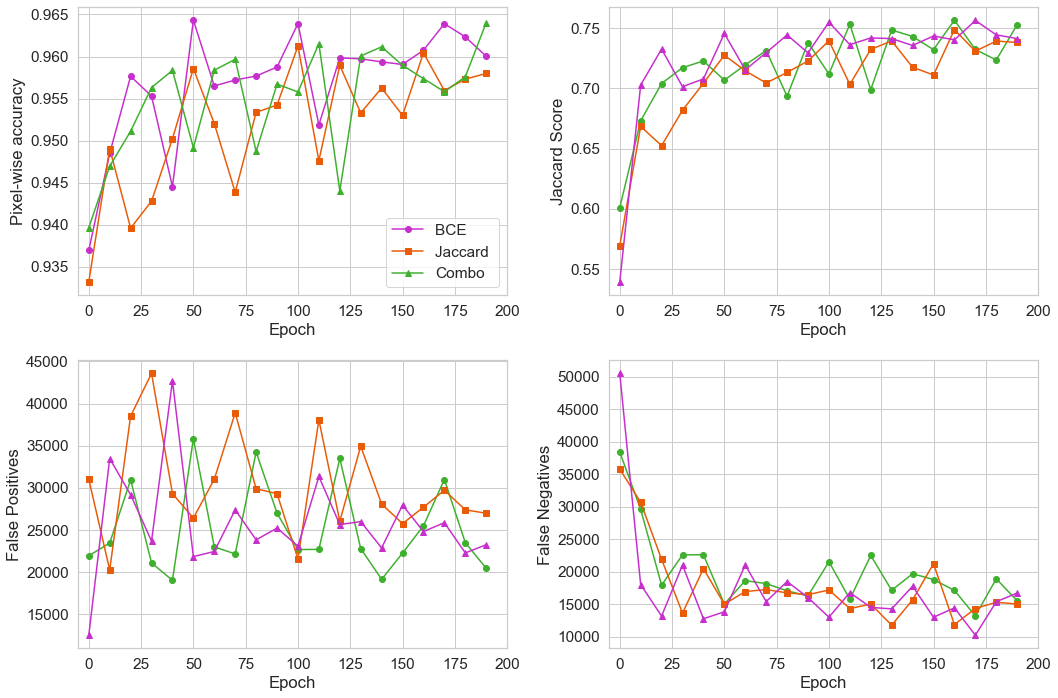

In [32]:
sns.set(font_scale=1.4) 
sns.set_style("whitegrid", {'axes.grid' : True})

fig, ax = plt.subplots(2,2, figsize=(15,10))

# Accuracy
ax[0,0].plot(np.arange(20)*10, base_metrics_trained['accuracy'], marker='o',label='BCE ',color=colours[0])
ax[0,0].plot(np.arange(20)*10, jaccard_metrics_trained['accuracy'], marker='s', label='Jaccard ',color=colours[1])
ax[0,0].plot(np.arange(20)*10, combo_metrics_trained['accuracy'], marker='^', label='Combo',color=colours[2])
ax[0,0].legend()
ax[0,0].set_xlabel("Epoch")
ax[0,0].set_ylabel("Pixel-wise accuracy")

# Jaccard
ax[0,1].plot(np.arange(20)*10, combo_metrics_trained['jaccard'], marker='o', label='combo',color=colours[2])
ax[0,1].plot(np.arange(20)*10, jaccard_metrics_trained['jaccard'], marker='s', label='jaccard',color=colours[1])
ax[0,1].plot(np.arange(20)*10, base_metrics_trained['jaccard'], marker='^', label='BCE',color=colours[0])
ax[0,1].set_xlabel("Epoch")
ax[0,1].set_ylabel("Jaccard Score")

# false positives
ax[1,0].plot(np.arange(20)*10, combo_metrics_trained['FP'], marker='o', label='combo',color=colours[2])
ax[1,0].plot(np.arange(20)*10, jaccard_metrics_trained['FP'], marker='s', label='jaccard',color=colours[1])
ax[1,0].plot(np.arange(20)*10, base_metrics_trained['FP'], marker='^', label='BCE',color=colours[0])
ax[1,0].set_xlabel("Epoch")
ax[1,0].set_ylabel("False Positives")

# false negatives
ax[1,1].plot(np.arange(20)*10, combo_metrics_trained['FN'], marker='o', label='combo',color=colours[2])
ax[1,1].plot(np.arange(20)*10, jaccard_metrics_trained['FN'], marker='s', label='jaccard',color=colours[1])
ax[1,1].plot(np.arange(20)*10, base_metrics_trained['FN'], marker='^', label='BCE',color=colours[0])
ax[1,1].set_xlabel("Epoch")
ax[1,1].set_ylabel("False Negatives")
plt.setp(ax, xlim=(-5,200))

# plt.savefig("val_metrics_per_epoch.pdf")
plt.tight_layout()
plt.show()

# Testing early stopping

In [33]:
def posthoc_early_stopping(pat, logs):
    last_loss = 100
    patience = pat
    triggertimes = 0
    done = 0

    for i in range(len(logs[2])):
        current_loss = logs[2][i]

        if current_loss > last_loss:
            trigger_times += 1

            if trigger_times >= patience:
                print(f'Epoch chosen after early stopping : {i}.')
                done = 1
                break

        else:
            trigger_times = 0

        last_loss = current_loss
        
    if done == 0:
        print("No epoch chosen with this patience.")
        
    return i 

In [34]:
early_stopping_epochs = [posthoc_early_stopping(4,base_log_loaded), 
                        posthoc_early_stopping(4,jaccard_log_loaded), 
                        posthoc_early_stopping(4,combo_log_loaded)]

Epoch chosen after early stopping : 91.
Epoch chosen after early stopping : 26.
Epoch chosen after early stopping : 72.


# Figures: final training logs, data examples

In [35]:
def test_analysis(testloader, logs, model_dict, num_epochs, image_folder,losstype):
    """
    inputs:
    testloader = dataloader with held-out test data
    model_dict = loaded model state dictionary from the best epoch
    num_epochs = how many epochs was the model trained for
    image_folder = where to store the output images
    losstype = 0,1,or2 : 0 = BCE, 1 = Jaccard, 2 = combo
    
    """
    net = UNet(3)
    net.load_state_dict(torch.load(model_dict))
    net.eval()
    
    # plotting training logs
    print("Training logs:")
    x_epoch = np.arange(num_epochs)

    fig, ax = plt.subplots(1,2,figsize=(12,5))
    ax[0].plot(x_epoch,torch.Tensor(np.stack(logs)[0]), label='Train loss',color=colours[0])
    ax[1].plot(x_epoch,torch.Tensor(np.stack(logs)[1]), label='Train acc',color=colours[0])
    ax[0].plot(x_epoch,torch.Tensor(np.stack(logs)[2]), label='Val loss',color=colours[2])
    ax[1].plot(x_epoch,torch.Tensor(np.stack(logs)[3]), label='Val acc',color=colours[2])
    
    ax[0].axvline(rounded[losstype],linestyle='--',color=colours[3])
    ax[1].axvline(rounded[losstype],linestyle='--',color=colours[3])
    
    ax[0].legend()
    ax[1].legend()
    
    if losstype==0:
        plt.suptitle("BCE Loss")
    elif losstype==1:
        plt.suptitle("Jaccard Loss")
    elif losstype==2:
        plt.suptitle("Combo Loss")
    plt.tight_layout()
#     plt.savefig(image_folder+"train_test_logs.png")
    plt.show()
    
    # final metrics
    print("Final test metrics:")
    final = final_performance_metric_calc(net, testloader)
    print(final)
    
    # calculating individual image metrics
    print("calculating individual image metrics...")
    
    TPs = []
    TNs = []
    FPs = []
    FNs = []
    test_masks = []
    test_images = []
    test_preds = []


    fprs = []
    fnrs = []
    hausdorfs = []
    dices = []
    accuracies = []
    jaccards = []
    msds = []
    vss = []
    sensitivities = []
    specificities = []


    with torch.no_grad():
        for x, y in testloader:
            x = x.to(device)
            y = (y>0.5).int()

            test_images.append(x.cpu())
            test_masks.append(y.cpu())

            pred = net(x)
            pred = torch.sigmoid(pred)
            
            pred = (pred > 0.5).int()

            test_preds.append(pred.cpu())

            pred = pred.cpu().numpy()
            y = y.cpu().numpy()
            
            TP = np.sum(np.logical_and(pred == 1, y == 1))
            TN = np.sum(np.logical_and(pred == 0, y == 0))
            FP = np.sum(np.logical_and(pred == 1, y == 0))
            FN = np.sum(np.logical_and(pred == 0, y == 1))

            TPs.append(TP)
            TNs.append(TN)
            FPs.append(FP)
            FNs.append(FN)


            metrics = sg.write_metrics(labels=[1],  # exclude background if needed
                                  gdth_img=y.squeeze(),
                                  pred_img=pred.squeeze(),
                                  )[0]
    
            accuracies.append((TP + TN) / (TP + FN + TN + FP))
            fprs.append(metrics['fpr'][0])
            fnrs.append(metrics['fnr'][0])
            hausdorfs.append(metrics['hd'][0])
            dices.append(metrics['dice'][0])
            vss.append(metrics['vs'][0])
            jaccards.append(metrics['jaccard'][0])
            msds.append(metrics['msd'][0])
            
            sensitivities.append(TP / (TP + FN))
            specificities.append(TN / (TN + FP))
            


            
    
    TPs = np.array(TPs); TNs = np.array(TNs); FPs = np.array(FPs); FNs = np.array(FNs)
    jaccards = np.array(jaccards); 
    NumSeg = TPs + FNs; NumPredSeg = TPs + FPs
    accuracy = (TPs + TNs) / (TPs + FNs + TNs + FPs)
    
    # when is the polyp underestimated 
    print("Predicted polyp smaller than real polyp:", np.sum(NumPredSeg < NumSeg))

    # when is the polyp overestimated 
    print("Predicted polyp larger than real polyp:", np.sum(NumPredSeg > NumSeg))

    # how many times is the segmentation completely missed? TPs == 0
    print(f"Predictions where polyp completely missed: {np.sum(TPs == 0)}")
    
    sns.set_style("whitegrid", {'axes.grid' : False})
    
    print("Lowest accuracy:")
    fig, ax_lowacc = plt.subplots(3,3, figsize=(9,9))
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    for i in range(3):
        ax_lowacc[i,0].imshow(tensor4d_to_plotnp(test_images[accuracy.argsort()[i]]))
        ax_lowacc[i,1].imshow(test_masks[accuracy.argsort()[i]].squeeze(),cmap='gray')
        ax_lowacc[i,2].imshow(test_preds[accuracy.argsort()[i]].squeeze(),cmap='gray')
    
    ax_lowacc[0,0].set_title("Real image")
    ax_lowacc[0,1].set_title("Ground truth")
    ax_lowacc[0,2].set_title("Prediction")
        
    plt.tight_layout()
#     plt.savefig(f"{losstype}_lowacc.pdf")
    plt.show()

    print("Highest accuracy:")
    fig, ax_highacc = plt.subplots(3,3, figsize=(9,9))
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    for i in range(3):
        ax_highacc[i,0].imshow(tensor4d_to_plotnp(test_images[accuracy.argsort()[-i-1]]))
        ax_highacc[i,1].imshow(test_masks[accuracy.argsort()[-i-1]].squeeze(),cmap='gray')
        ax_highacc[i,2].imshow(test_preds[accuracy.argsort()[-i-1]].squeeze(),cmap='gray')
        
    ax_highacc[0,0].set_title("Real image")
    ax_highacc[0,1].set_title("Ground truth")
    ax_highacc[0,2].set_title("Prediction")
    
    plt.tight_layout()
#     plt.savefig(f"{losstype}_highacc.pdf")
    plt.show()
    
    
    print("Lowest Jaccard:")
    fig, ax_lowjac = plt.subplots(3,3, figsize=(9,9))
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    for i in range(3):
        ax_lowjac[i,0].imshow(tensor4d_to_plotnp(test_images[jaccards.argsort()[i]]))
        ax_lowjac[i,1].imshow(test_masks[jaccards.argsort()[i]].squeeze(),cmap='gray')
        ax_lowjac[i,2].imshow(test_preds[jaccards.argsort()[i]].squeeze(),cmap='gray')
    
    ax_lowjac[0,0].set_title("Real image")
    ax_lowjac[0,1].set_title("Ground truth")
    ax_lowjac[0,2].set_title("Prediction")
    
    
    plt.tight_layout()
#     plt.savefig(f"{losstype}_lowj.pdf")
    plt.show()

    print("Highest Jaccard:")
    fig, ax_highjac = plt.subplots(3,3, figsize=(9,9))
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    for i in range(3):
        ax_highjac[i,0].imshow(tensor4d_to_plotnp(test_images[jaccards.argsort()[-i-1]]))
        ax_highjac[i,1].imshow(test_masks[jaccards.argsort()[-i-1]].squeeze(),cmap='gray')
        ax_highjac[i,2].imshow(test_preds[jaccards.argsort()[-i-1]].squeeze(),cmap='gray')
    
    ax_highjac[0,0].set_title("Real image")
    ax_highjac[0,1].set_title("Ground truth")
    ax_highjac[0,2].set_title("Prediction")
    
    plt.tight_layout()
#     plt.savefig(f"{losstype}_highj.pdf")
    plt.show()
    
    combos = accuracy + jaccards
    
    print("Lowest combos:")
    fig, ax_lowhd = plt.subplots(3,3, figsize=(9,9))
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    for i in range(3):
        ax_lowhd[i,0].imshow(tensor4d_to_plotnp(test_images[combos.argsort()[i]]))
        ax_lowhd[i,1].imshow(test_masks[combos.argsort()[i]].squeeze(),cmap='gray')
        ax_lowhd[i,2].imshow(test_preds[combos.argsort()[i]].squeeze(),cmap='gray')
    
    ax_lowhd[0,0].set_title("Real image")
    ax_lowhd[0,1].set_title("Ground truth")
    ax_lowhd[0,2].set_title("Prediction")
    
    
    plt.tight_layout()
#     plt.savefig(f"{losstype}_lowcom.pdf")
    plt.show()

    print("Highest combos:")
    fig, ax_highhd = plt.subplots(3,3, figsize=(9,9))
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    for i in range(3):
        ax_highhd[i,0].imshow(tensor4d_to_plotnp(test_images[combos.argsort()[-i-1]]))
        ax_highhd[i,1].imshow(test_masks[combos.argsort()[-i-1]].squeeze(),cmap='gray')
        ax_highhd[i,2].imshow(test_preds[combos.argsort()[-i-1]].squeeze(),cmap='gray')
    
    ax_highhd[0,0].set_title("Real image")
    ax_highhd[0,1].set_title("Ground truth")
    ax_highhd[0,2].set_title("Prediction")
    
    plt.tight_layout()
#     plt.savefig(f"{losstype}_highcom.pdf")
    plt.show()
    
    return final, [fprs, fnrs, accuracies, jaccards, hausdorfs, msds, sensitivities, specificities]

Training logs:


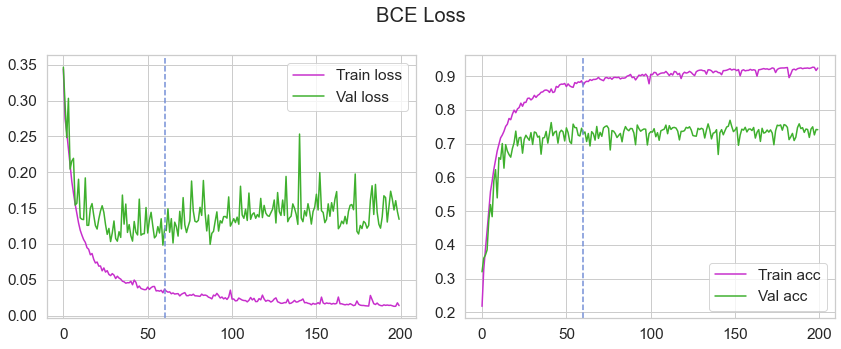

Final test metrics:
{'jaccard': 0.7086352200260579, 'accuracy': 0.944, 'sensitivity': 0.817062621992012, 'specificity': 0.9705012934852768, 'TP': 125881, 'TN': 818119, 'FP': 25476, 'FN': 30524}
calculating individual image metrics...


1it [00:00, 96.45it/s]
1it [00:00, 131.72it/s]
1it [00:00, 115.09it/s]
1it [00:00, 129.08it/s]
1it [00:00, 126.18it/s]
1it [00:00, 128.75it/s]
1it [00:00, 141.74it/s]
1it [00:00, 129.58it/s]
1it [00:00, 135.89it/s]
1it [00:00, 137.19it/s]
1it [00:00, 135.32it/s]
1it [00:00, 131.10it/s]
1it [00:00, 124.50it/s]
1it [00:00, 131.08it/s]
1it [00:00, 127.49it/s]
1it [00:00, 133.47it/s]
1it [00:00, 114.16it/s]
1it [00:00, 124.58it/s]
1it [00:00, 135.70it/s]
1it [00:00, 120.95it/s]
1it [00:00, 135.67it/s]
1it [00:00, 126.97it/s]
1it [00:00, 127.70it/s]
1it [00:00, 125.03it/s]
1it [00:00, 122.97it/s]
1it [00:00, 123.14it/s]
1it [00:00, 120.07it/s]
1it [00:00, 129.69it/s]
1it [00:00, 133.89it/s]
1it [00:00, 133.36it/s]
1it [00:00, 127.82it/s]
1it [00:00, 132.80it/s]
1it [00:00, 129.45it/s]
1it [00:00, 117.59it/s]
1it [00:00, 128.01it/s]
1it [00:00, 121.12it/s]
1it [00:00, 138.50it/s]
1it [00:00, 136.55it/s]
1it [00:00, 119.53it/s]
1it [00:00, 124.63it/s]
1it [00:00, 141.82it/s]
1it [00:00, 130.8

Predicted polyp smaller than real polyp: 50
Predicted polyp larger than real polyp: 48
Predictions where polyp completely missed: 2
Lowest accuracy:


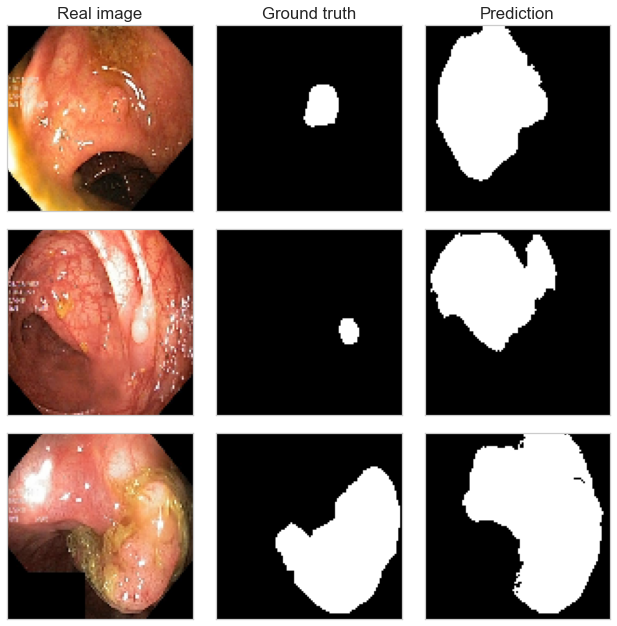

Highest accuracy:


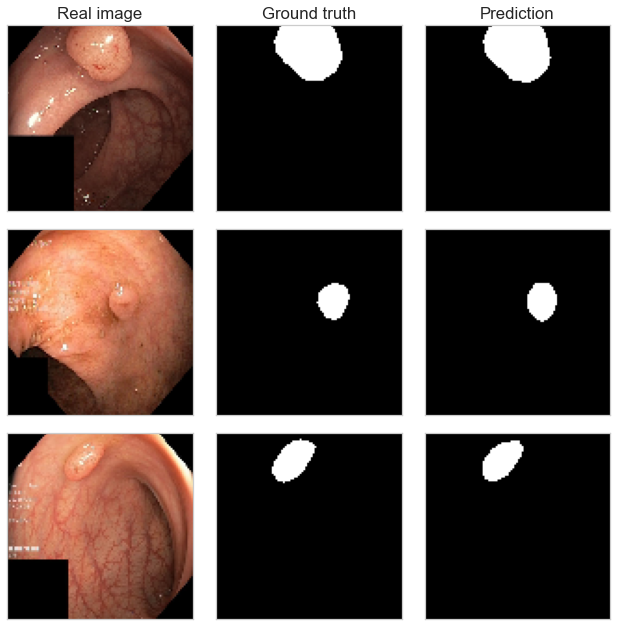

Lowest Jaccard:


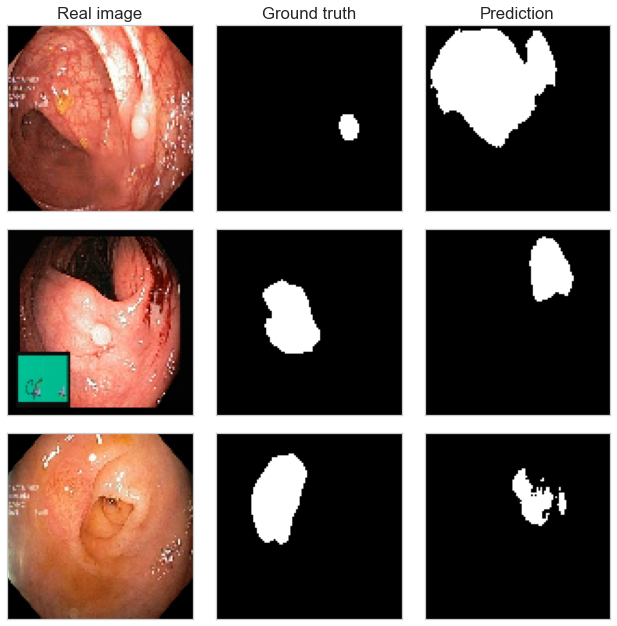

Highest Jaccard:


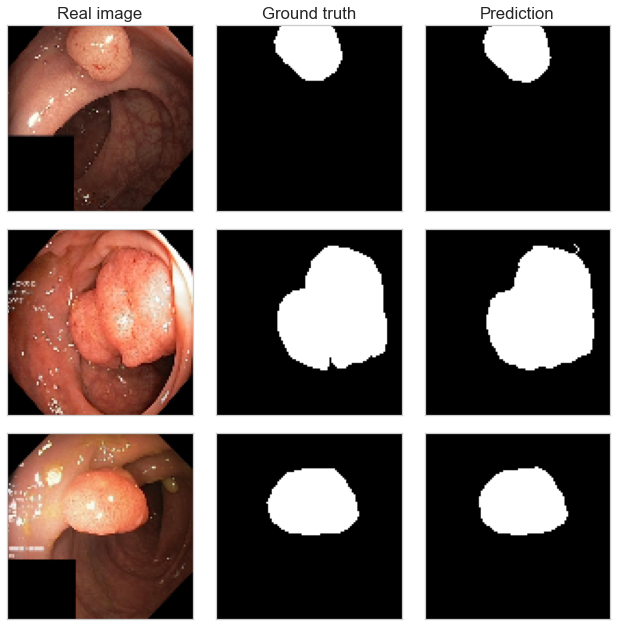

Lowest combos:


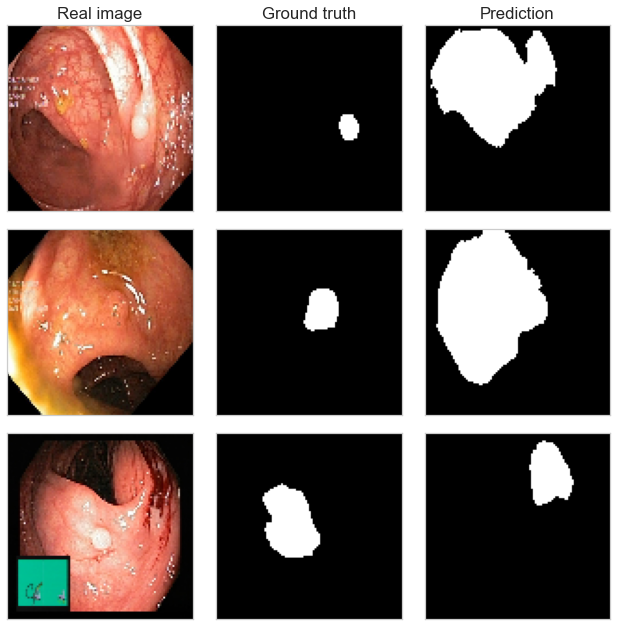

Highest combos:


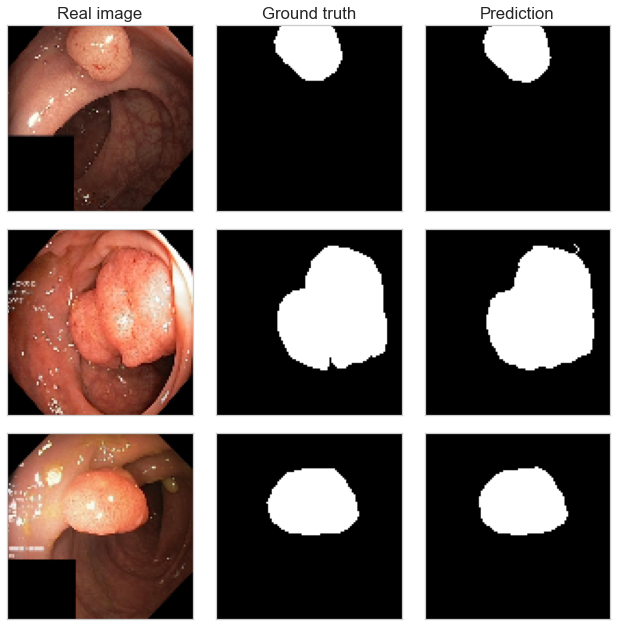

In [36]:
# BCE analysis
final_base, bce_mets = test_analysis(testloader=testloader, 
              logs=base_log_loaded, 
              model_dict=f"toload/BCEepoch{rounded[0]}.pth", 
              num_epochs=training_n_epochs,
              image_folder="base_unet_checkpoints/figures/",
                losstype=0)

Training logs:


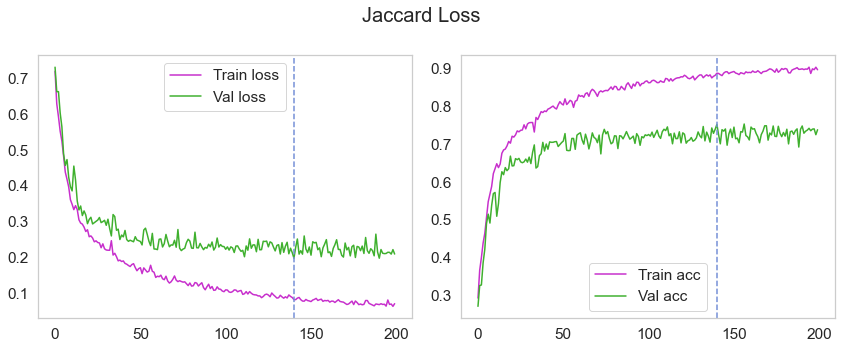

Final test metrics:
{'jaccard': 0.7378512638200947, 'accuracy': 0.948988, 'sensitivity': 0.8561651930524267, 'specificity': 0.9697310761625869, 'TP': 130395, 'TN': 818593, 'FP': 25002, 'FN': 26010}
calculating individual image metrics...


1it [00:00, 130.70it/s]
1it [00:00, 126.55it/s]
1it [00:00, 122.91it/s]
1it [00:00, 119.33it/s]
1it [00:00, 126.88it/s]
1it [00:00, 123.89it/s]
1it [00:00, 129.55it/s]
1it [00:00, 134.46it/s]
1it [00:00, 125.53it/s]
1it [00:00, 131.11it/s]
1it [00:00, 132.07it/s]
1it [00:00, 132.54it/s]
1it [00:00, 135.48it/s]
1it [00:00, 130.31it/s]
1it [00:00, 122.93it/s]
1it [00:00, 125.82it/s]
1it [00:00, 128.26it/s]
1it [00:00, 133.12it/s]
1it [00:00, 128.82it/s]
1it [00:00, 123.95it/s]
1it [00:00, 124.70it/s]
1it [00:00, 134.08it/s]
1it [00:00, 122.73it/s]
1it [00:00, 110.43it/s]
1it [00:00, 110.32it/s]
1it [00:00, 110.68it/s]
1it [00:00, 126.81it/s]
1it [00:00, 125.06it/s]
1it [00:00, 121.49it/s]
1it [00:00, 135.32it/s]
1it [00:00, 135.68it/s]
1it [00:00, 132.19it/s]
1it [00:00, 104.35it/s]
1it [00:00, 123.87it/s]
1it [00:00, 122.64it/s]
1it [00:00, 126.43it/s]
1it [00:00, 107.51it/s]
1it [00:00, 132.45it/s]
1it [00:00, 123.13it/s]
1it [00:00, 135.70it/s]
1it [00:00, 122.53it/s]
1it [00:00, 129.

Predicted polyp smaller than real polyp: 53
Predicted polyp larger than real polyp: 47
Predictions where polyp completely missed: 2
Lowest accuracy:


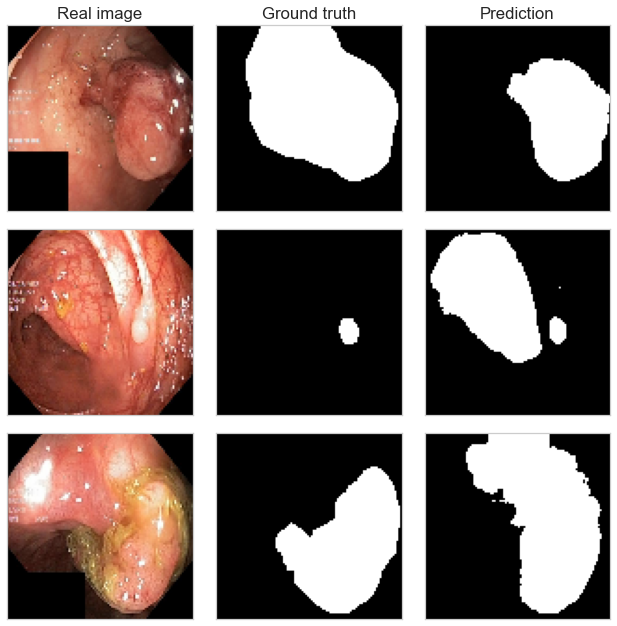

Highest accuracy:


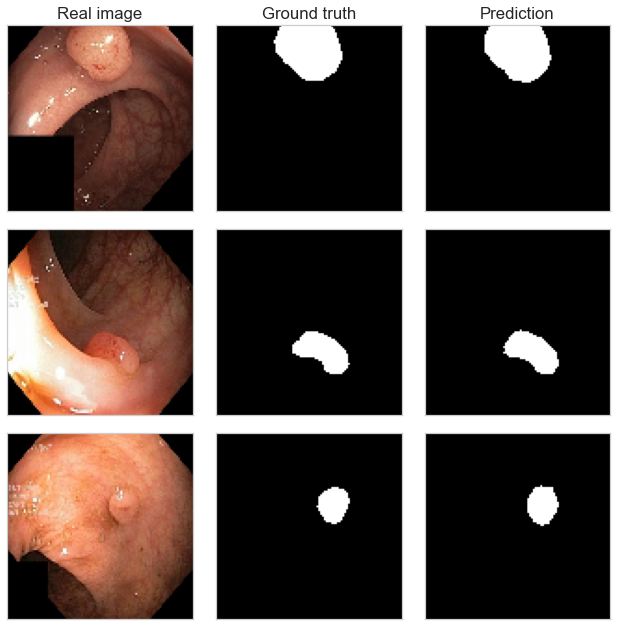

Lowest Jaccard:


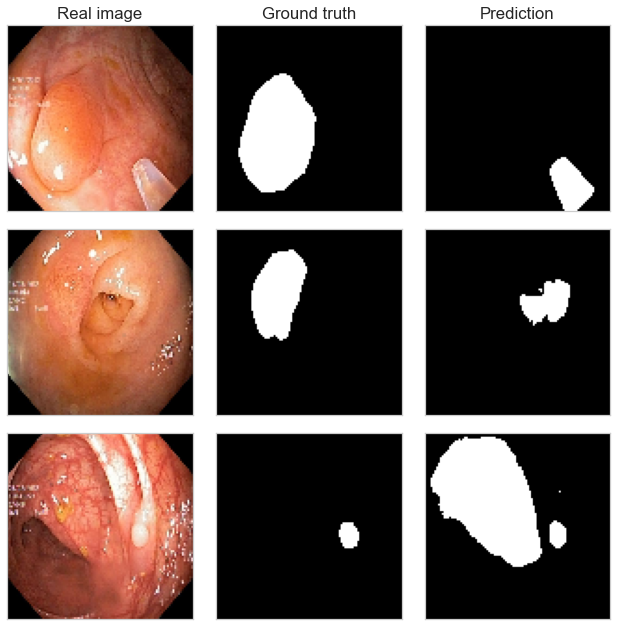

Highest Jaccard:


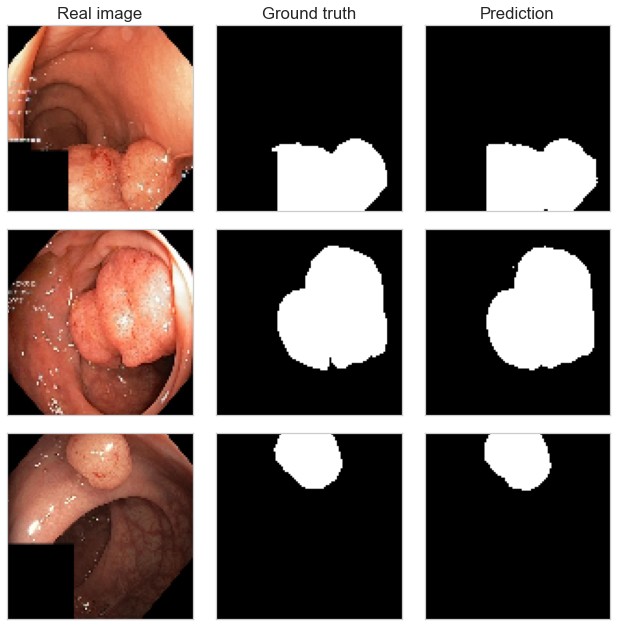

Lowest combos:


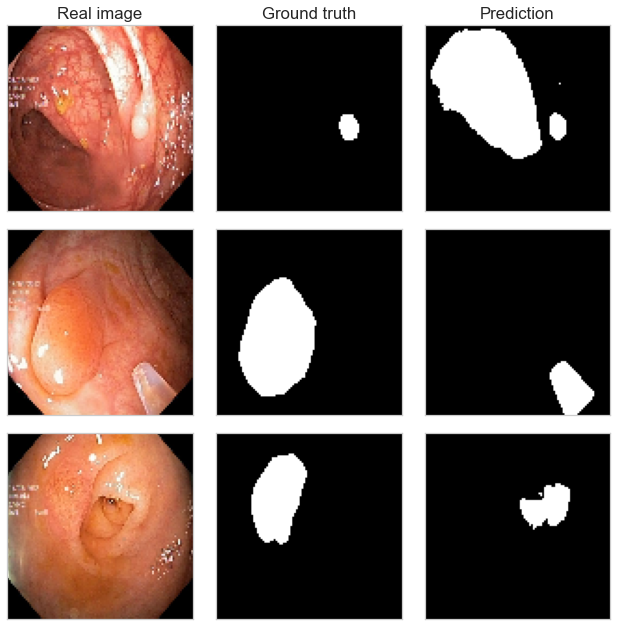

Highest combos:


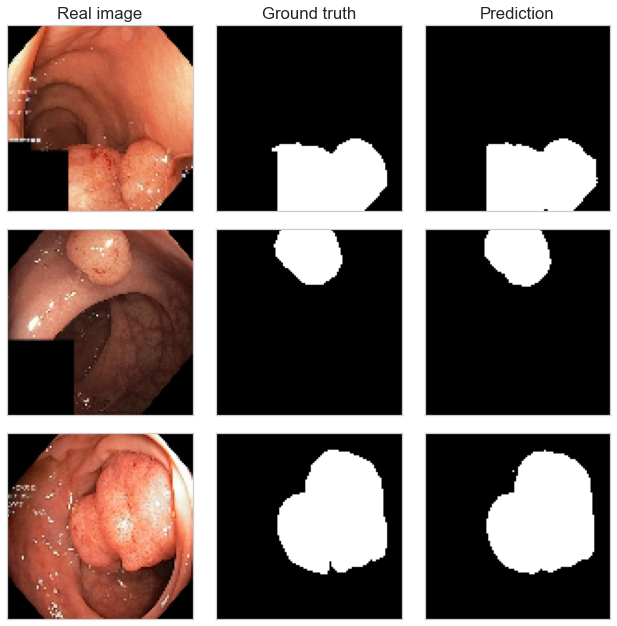

In [37]:
# jaccard analysis
final_jac, jac_mets = test_analysis(testloader=testloader, 
              logs=jaccard_log_loaded, 
            model_dict=f"toload/JSepoch{rounded[1]}.pth", 
              num_epochs=training_n_epochs,
              image_folder="IoU_unet_checkpoints/figures/",
            losstype=1)

Training logs:


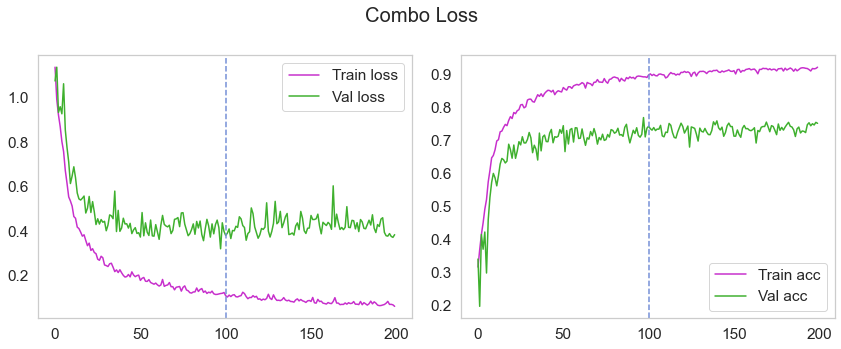

Final test metrics:
{'jaccard': 0.7431571951248667, 'accuracy': 0.9501220000000002, 'sensitivity': 0.8645283266839201, 'specificity': 0.9670555337108209, 'TP': 134167, 'TN': 815955, 'FP': 27640, 'FN': 22238}
calculating individual image metrics...


1it [00:00, 112.93it/s]
1it [00:00, 128.63it/s]
1it [00:00, 127.68it/s]
1it [00:00, 125.58it/s]
1it [00:00, 143.33it/s]
1it [00:00, 132.33it/s]
1it [00:00, 145.28it/s]
1it [00:00, 128.32it/s]
1it [00:00, 123.62it/s]
1it [00:00, 120.35it/s]
1it [00:00, 131.75it/s]
1it [00:00, 131.17it/s]
1it [00:00, 133.90it/s]
1it [00:00, 131.30it/s]
1it [00:00, 100.62it/s]
1it [00:00, 124.44it/s]
1it [00:00, 128.17it/s]
1it [00:00, 142.21it/s]
1it [00:00, 128.47it/s]
1it [00:00, 130.57it/s]
1it [00:00, 126.38it/s]
1it [00:00, 135.17it/s]
1it [00:00, 124.59it/s]
1it [00:00, 134.76it/s]
1it [00:00, 138.47it/s]
1it [00:00, 125.99it/s]
1it [00:00, 124.04it/s]
1it [00:00, 124.44it/s]
1it [00:00, 123.43it/s]
1it [00:00, 135.83it/s]
1it [00:00, 117.49it/s]
1it [00:00, 115.94it/s]
1it [00:00, 124.19it/s]
1it [00:00, 122.57it/s]
1it [00:00, 132.90it/s]
1it [00:00, 136.70it/s]
1it [00:00, 131.98it/s]
1it [00:00, 125.31it/s]
1it [00:00, 121.20it/s]
1it [00:00, 127.06it/s]
1it [00:00, 118.06it/s]
1it [00:00, 125.

Predicted polyp smaller than real polyp: 45
Predicted polyp larger than real polyp: 53
Predictions where polyp completely missed: 2
Lowest accuracy:


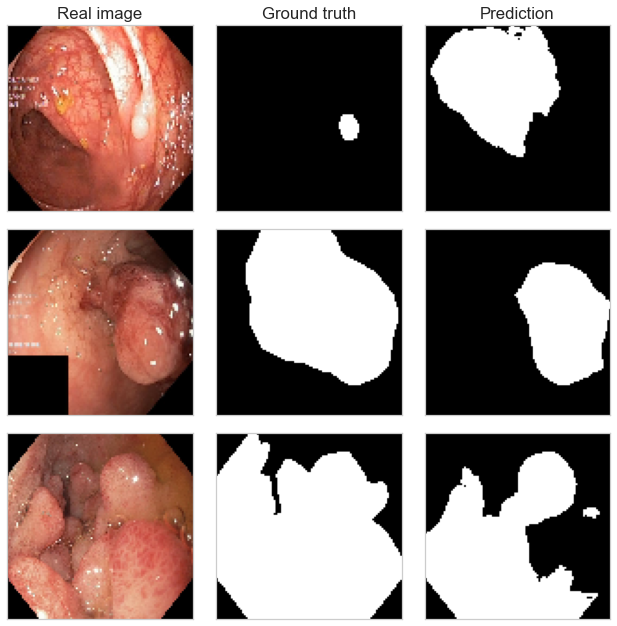

Highest accuracy:


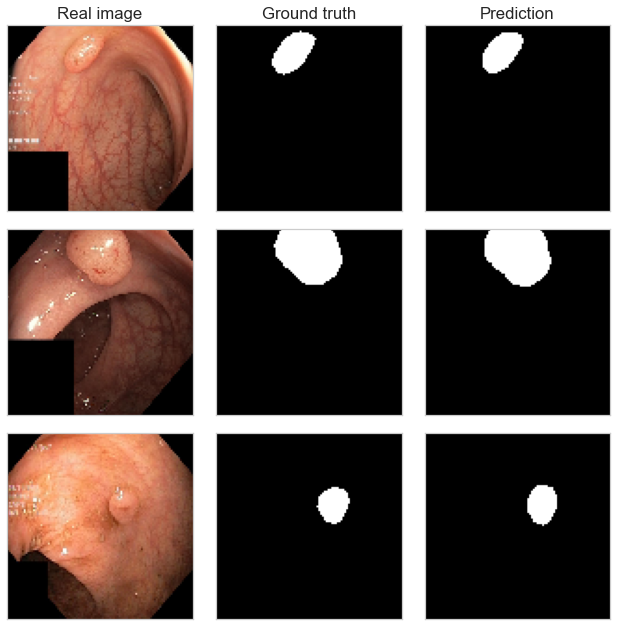

Lowest Jaccard:


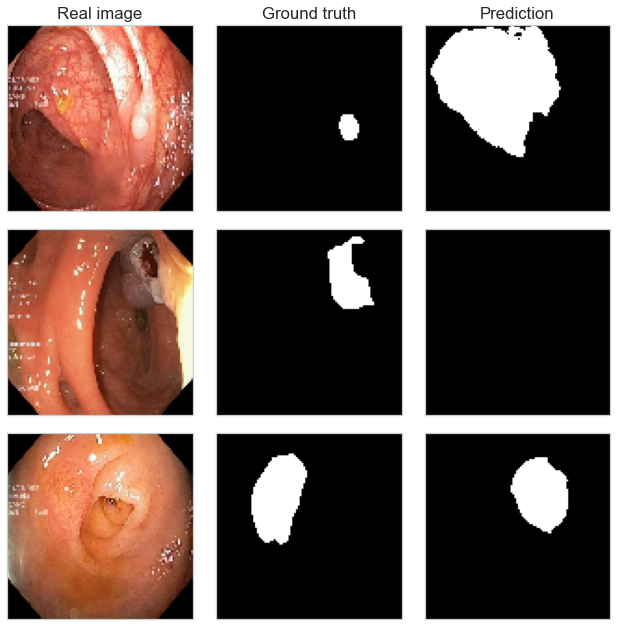

Highest Jaccard:


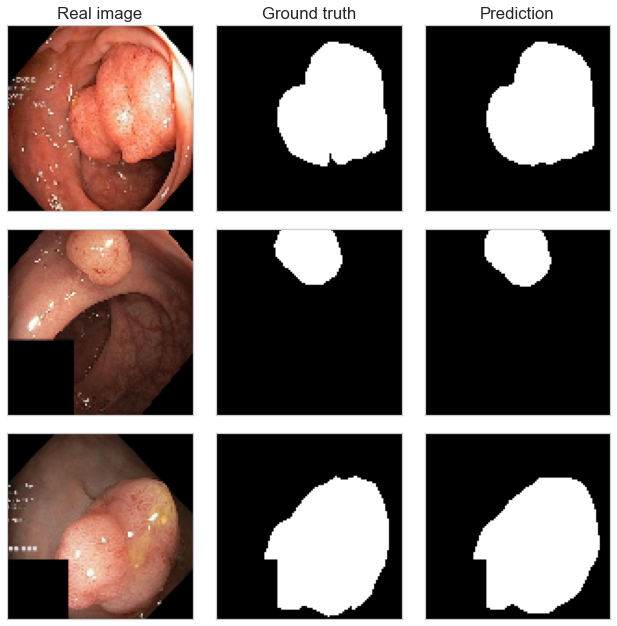

Lowest combos:


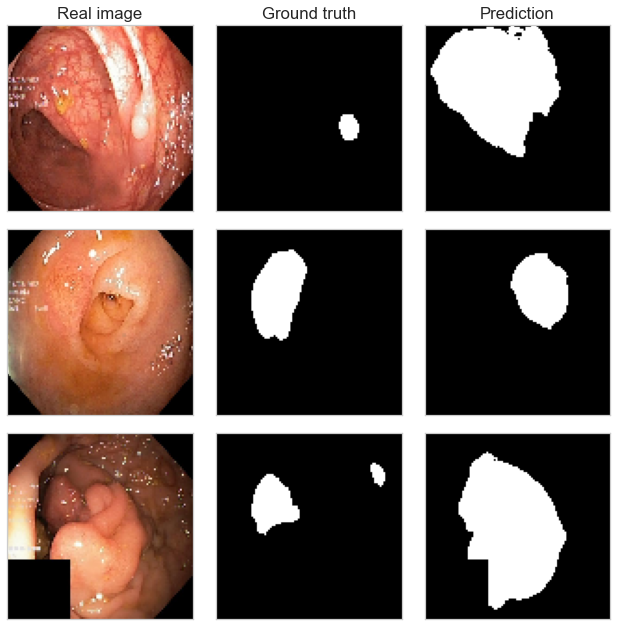

Highest combos:


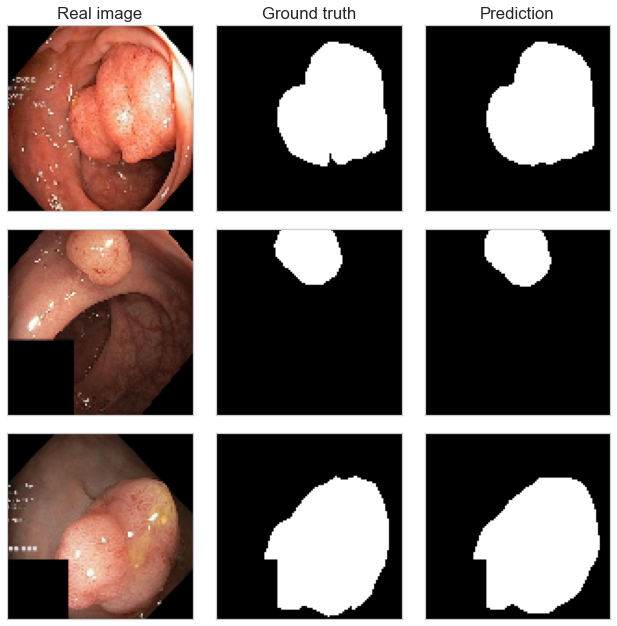

In [38]:
final_combo, com_mets = test_analysis(testloader=testloader, 
                            logs=combo_log_loaded, 
                            model_dict=f"toload/Comboepoch{rounded[2]}.pth", 
                            num_epochs=training_n_epochs,
                            image_folder="combo_unet_checkpoints/figures/",
                            losstype=2)

In [39]:
labels = ['FPR','FNR','Pixel-wise Accuracy','Jaccard Score','Hausdorff Distance','Mean Surface Distance','Sensitivity','Specificity']

In [40]:
def autolabel(rects):
    # credit: https://web.archive.org/web/20170228011551/http://matplotlib.org/examples/api/barchart_demo.html
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [41]:
# HD and MSD have infinite value in the combo net results
# getting rid of the infinite number - changing it to be equal to the next largest element

com_mets[4][np.argsort(np.array(com_mets[4]))[-1]] = com_mets[4][np.argsort(np.array(com_mets[4]))[-2]]

com_mets[5][np.argsort(np.array(com_mets[5]))[-1]] = com_mets[5][np.argsort(np.array(com_mets[5]))[-2]]



In [42]:
# significance testing
print("BCE and Jaccard:")
for i in range(len(jac_mets)):
    p = ttest_ind(bce_mets[i], jac_mets[i]).pvalue
    if p < 0.05:
        print(f"Significant - {p} - {labels[i]}")
        
print("BCE and Combo:")
for i in range(len(jac_mets)):
    p = ttest_ind(bce_mets[i], com_mets[i]).pvalue
    if p < 0.05:
        print(f"Significant - {p} - {labels[i]}")
        
print("Jaccard and Combo:")
for i in range(len(jac_mets)):
    p = ttest_ind(bce_mets[i], com_mets[i]).pvalue
    if p < 0.05:
        print(f"Significant - {p} - {labels[i]}")

BCE and Jaccard:
BCE and Combo:
Jaccard and Combo:


# Figure: boxplots of test set metrics

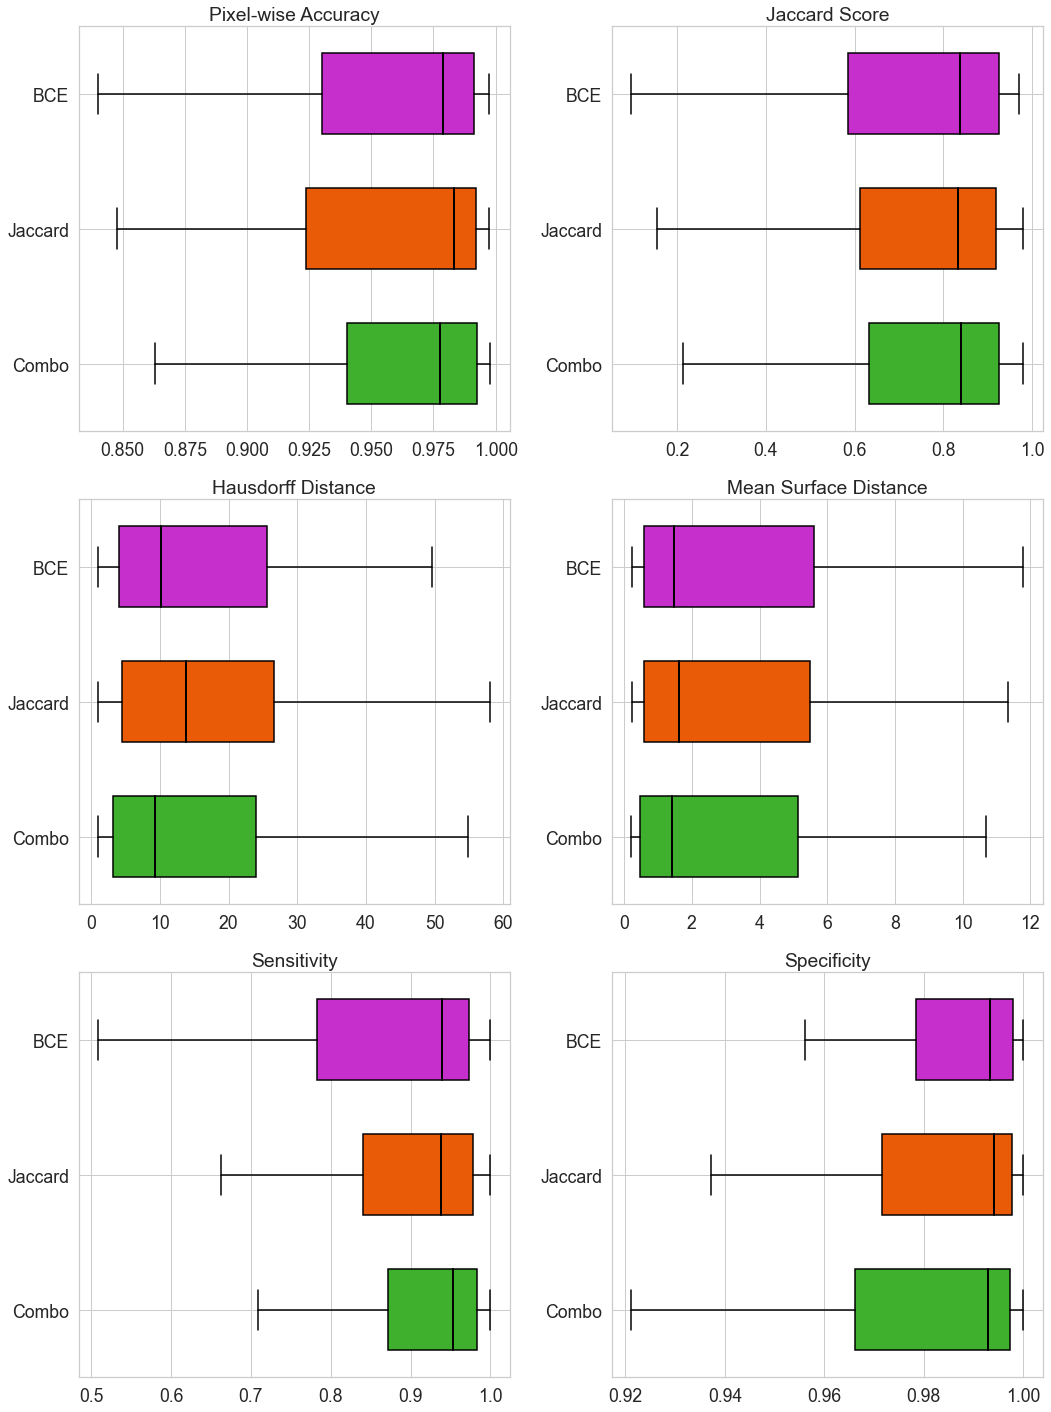

In [43]:
idx = 0
sns.set(font_scale=1.6) 
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(3,2, figsize=(15,20))
for i in range(0,3):
    for j in range(0,2):
        box1 = ax[i,j].boxplot(bce_mets[idx+2],positions=[2], 
                               patch_artist=True, boxprops=dict(facecolor=colours[0],linewidth=1.5),
                              medianprops=dict(linestyle='-', linewidth=2, color='black'),
                              widths=(0.6),whiskerprops=dict(linestyle='-', linewidth=1.5),
                               showfliers=False,
                              capprops=dict(linestyle='-', linewidth=1.5),
                              flierprops = dict(marker='o', markerfacecolor=colours[0], 
                                                markersize=5, linestyle='none', markeredgecolor=colours[0]),
                              vert=False)
        
        box2 = ax[i,j].boxplot(jac_mets[idx+2],positions=[1], patch_artist=True, 
                               boxprops=dict(facecolor=colours[1],linewidth=1.5),
                              medianprops=dict(linestyle='-', linewidth=2, color='black'),
                              widths=(0.6),whiskerprops=dict(linestyle='-', linewidth=1.5),
                               showfliers=False,
                              capprops=dict(linestyle='-', linewidth=1.5),
                              flierprops = dict(marker='o', markerfacecolor=colours[1], 
                                                markersize=5, linestyle='none', markeredgecolor=colours[1]),
                              vert=False)
        
        box3 = ax[i,j].boxplot(com_mets[idx+2],positions=[0], patch_artist=True, 
                               boxprops=dict(facecolor=colours[2],linewidth=1.5),
                              medianprops=dict(linestyle='-', linewidth=2, color='black'),
                              widths=(0.6),whiskerprops=dict(linestyle='-', linewidth=1.5),
                               showfliers=False,
                              capprops=dict(linestyle='-', linewidth=1.5),
                              flierprops = dict(marker='o', markerfacecolor=colours[2], 
                                                markersize=5, linestyle='none', markeredgecolor=colours[2]),
                              vert=False)

        
        ax[i,j].set_yticks(ticks=[0,1,2],labels=['Combo', 'Jaccard', 'BCE'])
        ax[i,j].set_title(labels[idx+2])
        
        idx+=1

plt.tight_layout()
# plt.savefig("boxplots.pdf")
plt.show()

# Figure: final held-out test set metrics

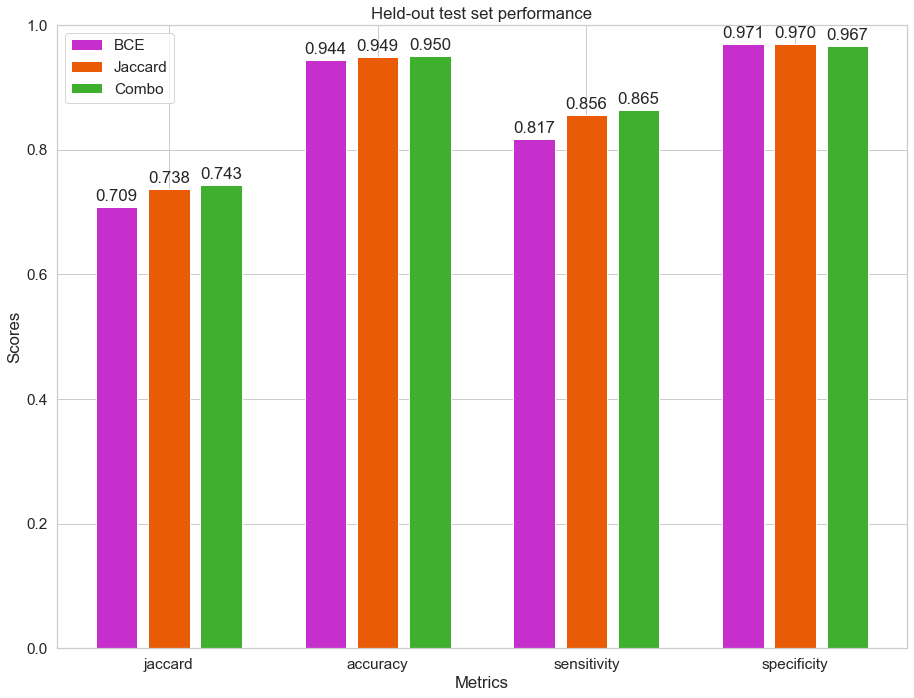

In [44]:
# data to plot
n_groups = 4
sns.set(font_scale=1.4) 
sns.set_style("whitegrid", {'axes.grid' : True})

base_bars = [final_base[key] for key in final_base]
jac_bars = [final_jac[key] for key in final_jac]
com_bars = [final_combo[key] for key in final_combo]

# create plot
fig, ax = plt.subplots(figsize=(13,10))
index = np.arange(n_groups)
bar_width = 0.2
opacity = 1

plt.bar(index - bar_width-0.05, base_bars[:4], bar_width,
alpha=opacity,
color=colours[0],
label='BCE')

plt.bar(index, jac_bars[:4], bar_width,
alpha=opacity,
color=colours[1],
label='Jaccard')

plt.bar(index + bar_width+0.05, com_bars[:4], bar_width,
alpha=opacity,
color=colours[2],
label='Combo')


plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Held-out test set performance')
plt.xticks(index, [key for key in final_base][:4])
plt.ylim(0,1)
plt.legend()

autolabel(ax.patches)
plt.tight_layout()
# plt.savefig("metrics_test.pdf")
plt.show()

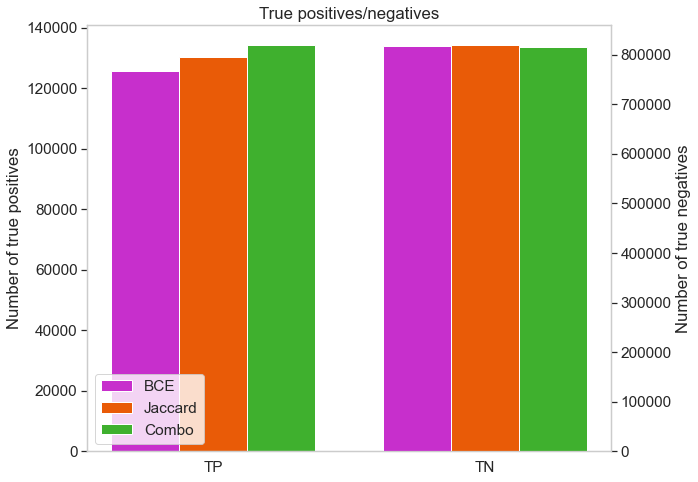

In [45]:
# data to plot
n_groups = 2
sns.set(font_scale=1.4) 
sns.set_style("whitegrid", {'axes.grid' : False})

# create plot
fig, ax_t = plt.subplots(figsize=(10,7))
axt2 = ax_t.twinx()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1

ax_t.bar(0 - bar_width, base_bars[4], bar_width,
        alpha=opacity,
        color=colours[0],
        label='BCE')

axt2.bar(1 - bar_width, base_bars[5], bar_width,
        alpha=opacity,
        color=colours[0],
        label='BCE')

ax_t.bar(0, jac_bars[4], bar_width,
        alpha=opacity,
        color=colours[1],
        label='Jaccard')

axt2.bar(1, jac_bars[5], bar_width,
        alpha=opacity,
        color=colours[1],
        label='Jaccard')

ax_t.bar(0 + bar_width, com_bars[4], bar_width,
        alpha=opacity,
        color=colours[2],
        label='Combo')

axt2.bar(1 + bar_width, com_bars[5], bar_width,
        alpha=opacity,
        color=colours[2],
        label='Combo')



plt.xlabel('Metrics')
ax_t.set_ylabel('Number of true positives')
axt2.set_ylabel('Number of true negatives')
plt.title('True positives/negatives')
plt.xticks(index, [key for key in base_metrics_trained][5:7])
plt.legend(loc='lower left')


plt.tight_layout()
# plt.savefig("TP_TN.pdf")
plt.show()

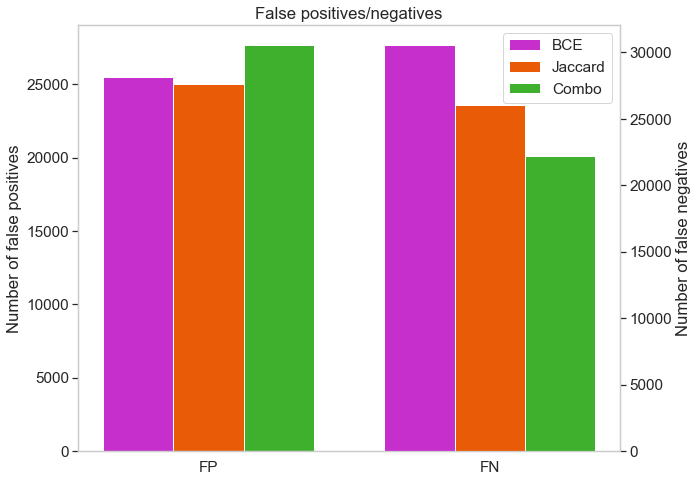

In [46]:
# data to plot
n_groups = 2
sns.set(font_scale=1.4) 
sns.set_style("whitegrid", {'axes.grid' : False})

# create plot
fig, ax_t = plt.subplots(figsize=(10,7))
axt2 = ax_t.twinx()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1

ax_t.bar(0-bar_width, base_bars[6], bar_width,
        alpha=opacity,
        color=colours[0],
        label='BCE')

axt2.bar(1-bar_width, base_bars[7], bar_width,
        alpha=opacity,
        color=colours[0],
        label='BCE')

ax_t.bar(0 , jac_bars[6], bar_width,
        alpha=opacity,
        color=colours[1],
        label='Jaccard')

axt2.bar(1 , jac_bars[7], bar_width,
        alpha=opacity,
        color=colours[1],
        label='Jaccard')

ax_t.bar(0 + bar_width, com_bars[6], bar_width,
        alpha=opacity,
        color=colours[2],
        label='Combo')

axt2.bar(1 + bar_width, com_bars[7], bar_width,
        alpha=opacity,
        color=colours[2],
        label='Combo')

plt.xlabel('Metrics')
ax_t.set_ylabel('Number of false positives')
axt2.set_ylabel('Number of false negatives')
plt.title('False positives/negatives')
plt.xticks(index, [key for key in base_metrics_trained][7:])
plt.legend()

plt.tight_layout()
# plt.savefig("FP_FN.pdf")
plt.show()

# Figure: polyp heatmap after augmentation

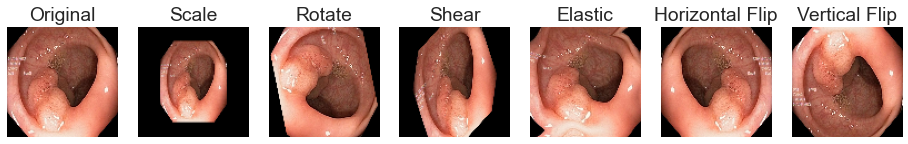

In [49]:
# examples of augmentations
auglabels = ['Scale','Rotate','Shear','Elastic','Horizontal Flip','Vertical Flip']
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set(font_scale=1.6) 
fig, ax = plt.subplots(1,7,figsize=(13,8))

im, ma = next(iter(noppdataloader))
ax[0].imshow(tensor4d_to_plotnp(im))
ax[0].axis('off')
ax[0].set_title('Original')


for i in range(len(augmentation_list)):
    augdataloader = torch.utils.data.DataLoader(basic_augmented_datasets[i], 
                                                        shuffle=False, 
                                                        batch_size=1, 
                                                        num_workers=0, 
                                                        pin_memory=False)
    
    ima, maa = next(iter(augdataloader))

    
    ax[i+1].imshow(tensor4d_to_plotnp(ima))
    ax[i+1].axis('off')
    ax[i+1].set_title(auglabels[i])

plt.tight_layout()
# plt.savefig("augexamples.pdf")
plt.show()

In [55]:
seg_count = 0
non_seg_count = 0
polyp_counter = 0

# look over every grouth truth segmentation
for x,y in tqdm(trainloader):
    y = (y > 0.5).float()
    seg_count += np.count_nonzero(y == 1)
    non_seg_count += np.count_nonzero(y == 0)
    polyp_counter = polyp_counter + y.numpy().squeeze()

  0%|          | 0/140 [00:00<?, ?it/s]

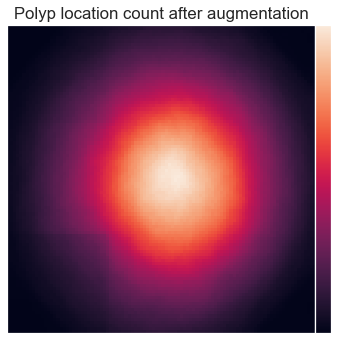

In [56]:
# fig, ax = plt.subplots(figsize=(7,7))
# pos = ax.imshow(np.sum(polyp_counter,axis=0))
# ax.set_title('Heatmap of polyp location after augmentation')
# fig.colorbar(pos,ax=ax, label='Count')
# plt.show()

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set(font_scale=1.4) 

fig, ax_hm_da = plt.subplots(figsize=(5,5))

pos = ax_hm_da.imshow(np.sum(polyp_counter,axis=0))
ax_hm_da.set_title('Polyp location count after augmentation')

divider = make_axes_locatable(ax_hm_da)
cax = divider.append_axes("right", size="5%", pad=0.0)
fig.colorbar(pos,cax=cax)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.tight_layout()
# plt.savefig('afteraug.pdf')